In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
from fastai.script import *
from fastai.vision import *
from fastai.callbacks import *
from fastai.distributed import *
from fastai.callbacks.tracker import *

torch.backends.cudnn.benchmark = True

import time

In [3]:
#from fastai.vision.models  import *

In [4]:
#!pip install git+https://github.com/fastai/fastai.git 

In [3]:
import fastai;fastai.__version__ #safety check

'1.0.58.dev0'

In [4]:
import torch; torch.__version__ #safety check

'1.2.0'

In [5]:
from res2fg import *

Mish activation loaded...


In [7]:
from qhadam import QHAdam

In [6]:
from autolr import autolr

In [5]:
from newranger import Ranger

In [6]:
from looknew import Lookahead

In [7]:
from lamb import Lamb

In [5]:
from rangerlamb import RangerLamb

In [7]:
from radam2 import RAdam

In [8]:
from over9000 import *

In [7]:
from adams import Adams

In [8]:
from novograd import Novograd

In [6]:
from rangernovo import RangerNovo   #get Ranger

ModuleNotFoundError: No module named 'rangernovo'

In [6]:
from ranger import Ranger

In [11]:
from radam import *

In [5]:
from mxresnet import *

Mish-R loaded...


In [9]:
from alig import AliG

IndentationError: expected an indented block (alig.py, line 45)

In [8]:
from blend import *  #this is extra data augmentation including cutmix and  ricap

ModuleNotFoundError: No module named 'blend'

In [6]:
#get ImageNette
path = untar_data(URLs.IMAGEWOOF); path

PosixPath('/home/ubuntu/.fastai/data/imagewoof')

In [7]:
#set image size, batch size 
size=128
bs = 64  

In [8]:
#from x2resnet import *

ModuleNotFoundError: No module named 'x2resnet'

In [14]:
class FlatCosAnnealScheduler(LearnerCallback):
    """
    Manage FCFit training as found in the ImageNette experiments. 
    Code format is based on OneCycleScheduler
    """
    def __init__(self, learn:Learner, lr:float=4e-3, moms:Floats=(0.95,0.999),
               start_pct:float=0.72, start_epoch:int=None,curve='cosine',
               tot_epochs:int=2):
        super().__init__(learn)
        n = len(learn.data.train_dl)
        self.anneal_start = int(n*tot_epochs*start_pct)
        self.batch_finish = (n*tot_epochs - self.anneal_start)
        phase0 = TrainingPhase(self.anneal_start).schedule_hp('lr', lr)
        if curve=="cosine":
            curve_type=annealing_cos
        elif curve=="linear":
            curve_type=annealing_linear
        elif curve=="exponential":
            curve_type=annealing_exp
        else:
            raiseValueError(f"annealing type not supported {curve}")
        phase1 = TrainingPhase(self.batch_finish).schedule_hp('lr', lr, anneal=curve_type)
        phases = [phase0, phase1]
        self.phases,self.start_epoch = phases,start_epoch


    def on_train_begin(self, epoch:int, **kwargs:Any)->None:
        "Initialize the schedulers for training."
        res = {'epoch':self.start_epoch} if self.start_epoch is not None else None
        self.start_epoch = ifnone(self.start_epoch, epoch)
        self.scheds = [p.scheds for p in self.phases]
        self.opt = self.learn.opt
        for k,v in self.scheds[0].items(): 
            v.restart()
            self.opt.set_stat(k, v.start)
        self.idx_s = 0
        return res
    
    def jump_to_epoch(self, epoch:int)->None:
        for _ in range(len(self.learn.data.train_dl) * epoch):
            self.on_batch_end(True)

    def on_batch_end(self, train, **kwargs:Any)->None:
        "Take a step in lr,mom sched, start next stepper when the current one is complete."
        if train:
            if self.idx_s >= len(self.scheds): return {'stop_training': True, 'stop_epoch': True}
            sched = self.scheds[self.idx_s]
            for k,v in sched.items(): self.opt.set_stat(k, v.step())
            if list(sched.values())[0].is_done: self.idx_s += 1

In [10]:
def fit_fc(learn:Learner, cyc_len:int, lr:float=defaults.lr,
                  moms:Tuple[float,float]=(0.95,0.85), start_pct:float=0.72,
                  wd:float=None, callbacks:Optional[CallbackList]=None, tot_epochs:int=None, show_curve:bool=False)->None:
    "Fit a model with Flat Cosine Annealing"
    max_lr = learn.lr_range(lr)
    callbacks = listify(callbacks)
    callbacks.append(FlatCosAnnealScheduler(learn, lr, start_pct=start_pct, tot_epochs=cyc_len))
    learn.fit(cyc_len, max_lr, wd=wd, callbacks=callbacks)
    if show_curve: learn.recorder.plot_lr()

In [22]:
#learn.fit(epochs=1, callbacks=OneCycleScheduler(learn, lr_max=0.003, div_factor=2, final_div=1e5, pct_start=0.7))


In [23]:
#learn.recorder.plot_lr()

In [24]:
#learn.recorder.plot_lr()

In [10]:
def fcfit(learn, num_epoch=1, lr=4e-3, start_pct=.72, curve="cosine",f_show_curve=True):
    if num_epoch<1:
        raiseValueError("num_epoch must be 1 or higher")
    n = len(learn.data.train_dl)
    anneal_start = int(n*num_epoch*start_pct) #compute what batch to start
    batch_finish = (n*num_epoch - anneal_start)
    phase0 = TrainingPhase(anneal_start).schedule_hp('lr', lr)
    if curve=="cosine":
        curve_type=annealing_cos
    elif curve=="linear":
        curve_type=annealing_linear
    elif curve=="exponential":
        curve_type=annealing_exp
    else:
        raiseValueError(f"annealing type not supported {curve}")
    phase1 = TrainingPhase(n*5 - anneal_start).schedule_hp('lr', lr, anneal=curve_type)
    phases = [phase0, phase1]
    sched = GeneralScheduler(learn, phases)
    #save the setup
    learn.callbacks.append(sched)
    #start the training
    print(f"fcfit: num_epochs: {num_epoch}, lr = {lr}") 
    print(f"Flat for {anneal_start} epochs, then {curve} anneal for {batch_finish}")
    learn.fit(num_epoch)
    #bonus -show lr curve?
    if f_show_curve:    
        learn.recorder.plot_lr()


In [21]:
#fcfit(learn, curve='exponential')

In [24]:
learn.purge;learn.destroy #used to reset learners

<bound method Learner.destroy of Learner(data=ImageDataBunch;

Train: LabelList (12454 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
n02093754,n02093754,n02093754,n02093754,n02093754
Path: /home/ubuntu/.fastai/data/imagewoof;

Valid: LabelList (500 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
n02093754,n02093754,n02093754,n02093754,n02093754
Path: /home/ubuntu/.fastai/data/imagewoof;

Test: None, model=Res2Net(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): Mish()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): Mish()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=Tru

In [31]:
tfms = ([

        flip_lr(p=0.5),#,#,
        #jitter(magnitude=.05)
        brightness(change=(0.4,0.6)),
        contrast(scale=(0.4,1))#,
        #rgb_randomize()
        #cutout(n_holes=(2,20),length=(5,20),p=plist[0],color=2)
        #cutout(n_holes=(8,15), length = (3,10),p=plist[0])
        #cutout(n_holes=(4,20),length=(5,40),p=.1)
        #cutout(n_holes=(4,12),length=(3,14),p=1)
        #cutout(n_holes=(6,14),length=(5,16),p=.8,color=2)

    ], [])

In [32]:
data = (ImageList.from_folder(path)
        .split_by_folder(valid='val')
        .label_from_folder()
        .transform(tfms=tfms,size=size) 
        .databunch(bs=bs, num_workers=8)  #windows 10 users - num_workers may need to be set to 1 or 0 (if you get pickle fork error)
        .presize(size, scale=(0.35, 1))
        .normalize(imagenet_stats))

In [53]:
#data.show_batch()

In [54]:
#data

In [55]:
#data.show_batch()

In [56]:
#def Ranger(params, alpha=0.5, k=6, *args, **kwargs):
     #radam = RAdam(params, *args, **kwargs)
     #return Lookahead(radam, alpha, k)


In [12]:
from qhadam import QHAdam

In [10]:
from rangerqh import RangerQH

In [15]:
#from rangertransformer import RangerTF

In [33]:
optar=partial(RangerQH,nus=(.70,1.0),betas=(0.92, 0.999),eps=1e-6)


In [104]:
#from ranger import Ranger

In [29]:
learn.purge;learn.destroy;gc.collect()

5906

In [24]:
#optar = partial(Ranger,betas=(.95,.99),eps=1e-5)#, amsgrad=True) #prep Ranger to be used.  k and alpha can be adjusted here

In [42]:
#from ranger import Ranger

In [72]:
#optar = partial(Ranger,lr=1.5,momentum=0, eps=1e-5, adjusted_momentum=False)

In [34]:
learn = Learner(data, res2net(num_classes=10), metrics=[accuracy], wd=1e-3,
                opt_func=optar,
                 bn_wd=False, true_wd=True,#),
                loss_func = LabelSmoothingCrossEntropy())

Mish activation loaded...
Mish activation loaded...
Mish activation loaded...
Mish activation loaded...
Mish activation loaded...
Mish activation loaded...
Mish activation loaded...
Mish activation loaded...
Mish activation loaded...
Mish activation loaded...
Mish activation loaded...
Mish activation loaded...
Mish activation loaded...
Mish activation loaded...
Mish activation loaded...
Mish activation loaded...


In [19]:
#t=FlatCosAnnealScheduler(learn)

In [13]:
from blendaug import *

In [ ]:
#t = Res2Net50()

In [48]:
#learn.fit(1,lr=.004)

In [49]:
#learn.recorder.plot_lr()

In [ ]:
#! cp basic_train.py ~/anaconda3/lib/python3.7/site-packages/fastai/basic_train.py 

In [ ]:
#! cp callback.py ~/anaconda3/lib/python3.7/site-packages/fastai/callback.py

In [35]:
learn.cutmix()

Learner(data=ImageDataBunch;

Train: LabelList (12454 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
n02093754,n02093754,n02093754,n02093754,n02093754
Path: /home/ubuntu/.fastai/data/imagewoof;

Valid: LabelList (500 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
n02093754,n02093754,n02093754,n02093754,n02093754
Path: /home/ubuntu/.fastai/data/imagewoof;

Test: None, model=Res2Net(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): Mish()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): Mish()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )


In [36]:
learn.callback_fns += [

        partial(ShowGraph),
        #FlatCosAnnealScheduler()
        #partial(SaveModelCallback, name='model-novotest-1')

    ]

In [24]:
learn.cutmix()

Learner(data=ImageDataBunch;

Train: LabelList (12454 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
n02093754,n02093754,n02093754,n02093754,n02093754
Path: /home/ubuntu/.fastai/data/imagewoof;

Valid: LabelList (500 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
n02093754,n02093754,n02093754,n02093754,n02093754
Path: /home/ubuntu/.fastai/data/imagewoof;

Test: None, model=Res2Net(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): Mish()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): Mish()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )


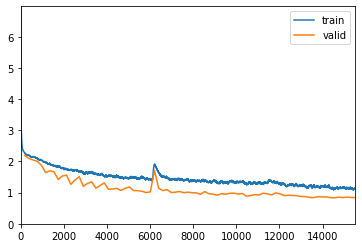

In [16]:
learn.fit_fc(80, lr=.0042)

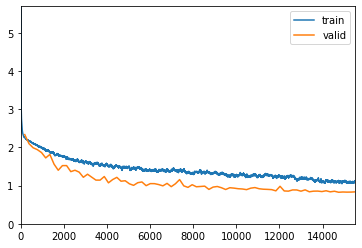

In [23]:
learn.fit_fc(80, lr=.0042)

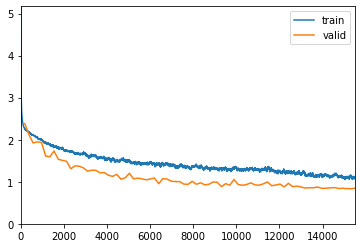

In [28]:
learn.fit_fc(80, lr=.0042)

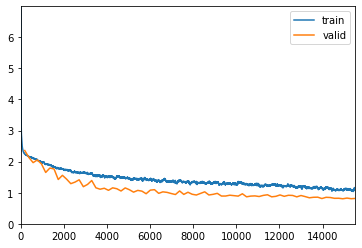

In [37]:
learn.fit_fc(80, lr=.0042) # final

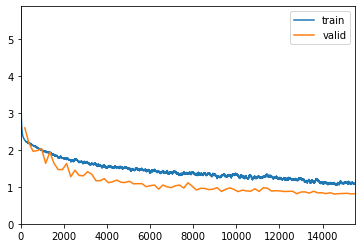

In [21]:
learn.fit_fc(80, lr=.0042) #1 run, LIP pooling

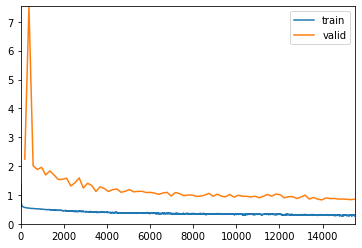

In [30]:
learn.fit_fc(80, lr=.0042) #ricap

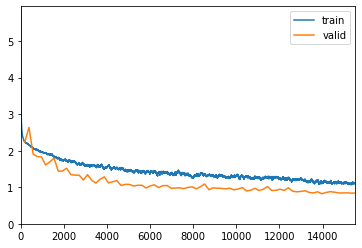

In [25]:
learn.fit_fc(80, lr=.0041)

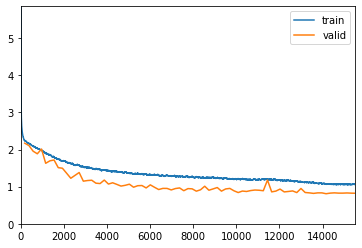

In [18]:
learn.fit_fc(80, lr=.004)

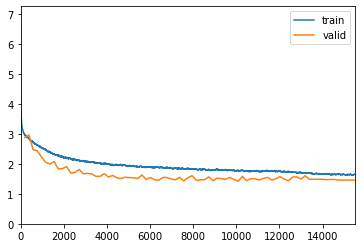

In [16]:
learn.fit_fc(80, lr=.004)

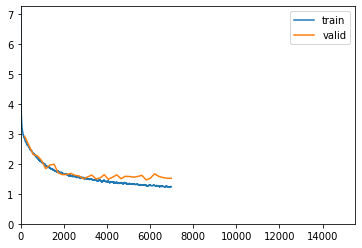

KeyboardInterrupt: 

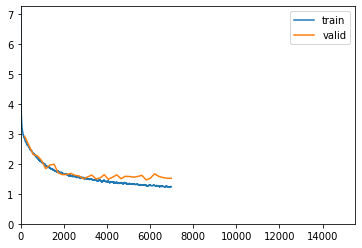

In [134]:
learn.fit_fc(80, lr=.004) #rangerqh .7

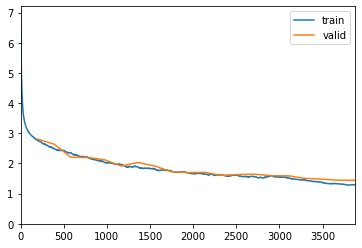

In [120]:
learn.fit_fc(20, lr=.004) #rangerqh .7

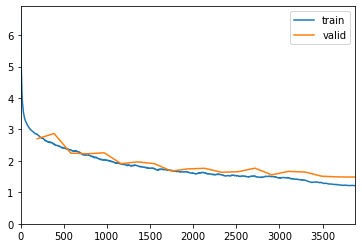

In [127]:
learn.fit_fc(20, lr=.0038) #rangerqh

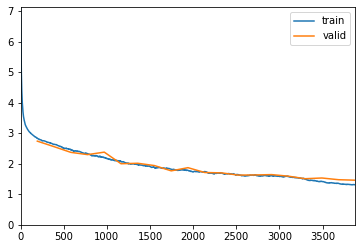

In [108]:
learn.fit_fc(20, lr=.004) #adam qh .8nus

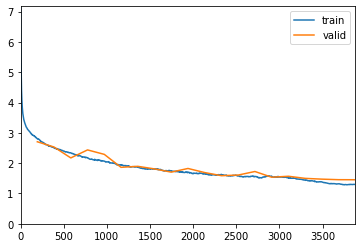

In [99]:
learn.fit_fc(20, lr=.004) #ranger qh .8nus

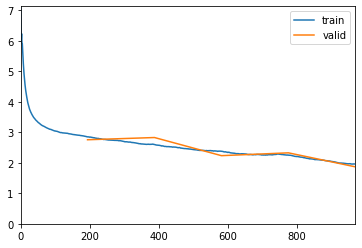

In [90]:
learn.fit_fc(5, lr=.004) #.7 nus

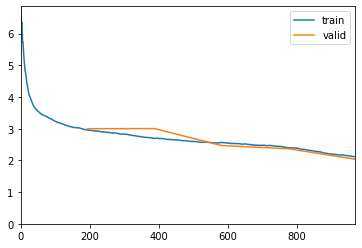

In [80]:
learn.fit_fc(5, lr=.004) #.4 nus

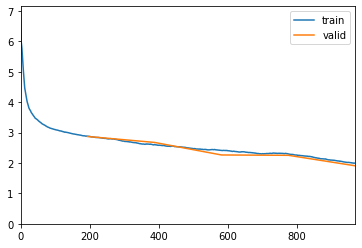

In [75]:
learn.fit_fc(5, lr=.004) #.6 nus

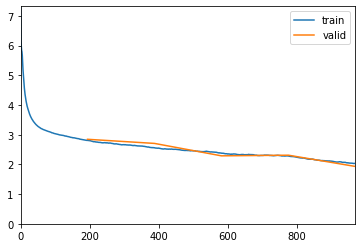

In [63]:
learn.fit_fc(15, lr=.004)

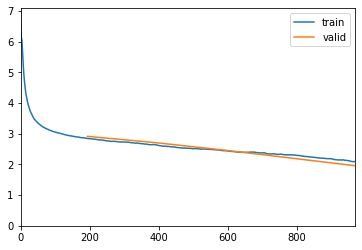

In [35]:
learn.fit_fc(5, lr=.004) #.9nus, .95 beta

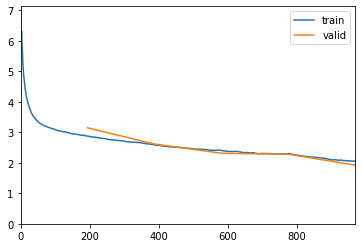

In [27]:
learn.fit_fc(5, lr=.004) #.8nus

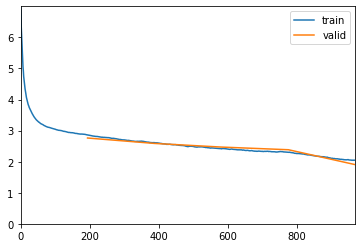

In [18]:
learn.fit_fc(5, lr=.004)

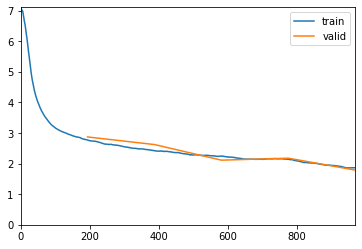

In [28]:
learn.fit_fc(5, lr=.004)

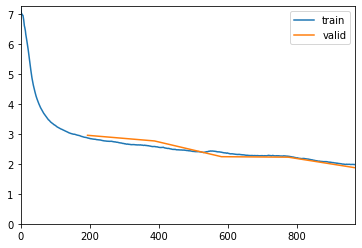

In [24]:
learn.fit_fc(5, lr=.004)

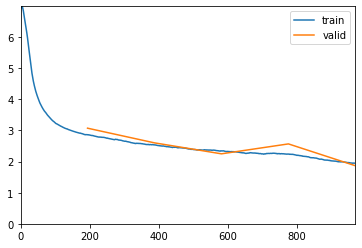

In [19]:
learn.fit_fc(5, lr=.004)

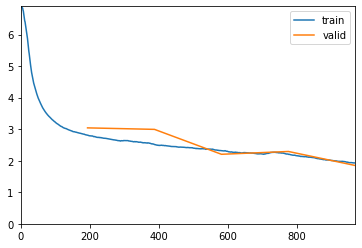

In [14]:
learn.fit_fc(5, lr=.004)

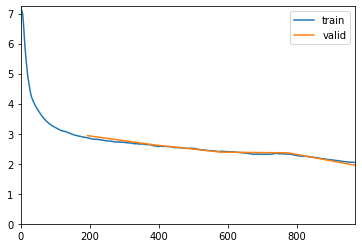

In [22]:
learn.fit_fc(5, lr=.004)

Mish-R loaded...


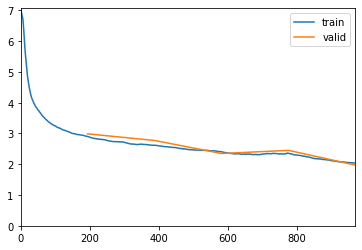

In [17]:
learn.fit_fc(5, lr=.004)

fcfit: num_epochs: 7, lr = 0.004
Flat for 977 epochs, then cosine anneal for 381
init and print of slow weights
2


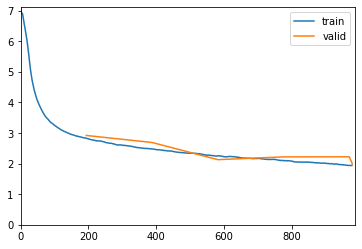

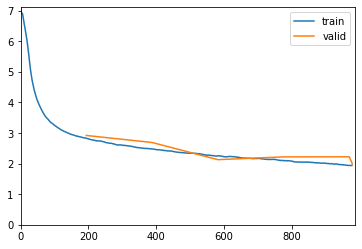

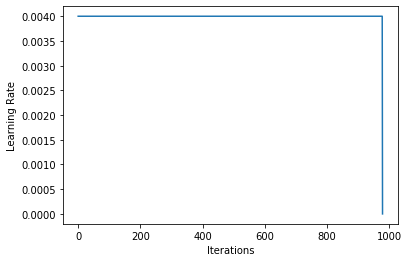

In [17]:
fcfit(learn,7, lr=.004)

fcfit: num_epochs: 20, lr = 0.0045
Flat for 2793 epochs, then cosine anneal for 1087
init and print of slow weights
2


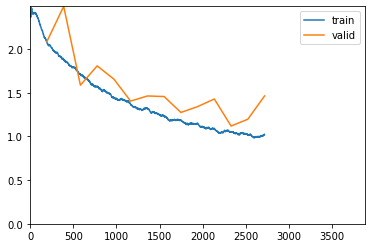

In [ ]:
fcfit(learn,7, lr=.004)

fcfit: num_epochs: 20, lr = 0.0045
Flat for 2793 epochs, then cosine anneal for 1087
init and print of slow weights
2


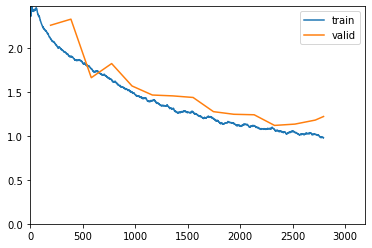

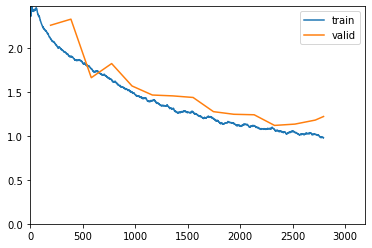

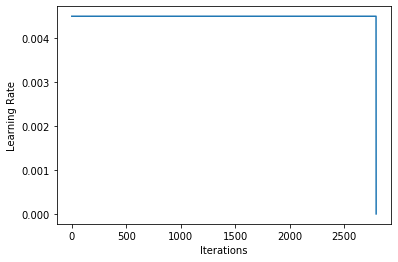

In [15]:
fcfit(learn,20,lr=.0045)

fcfit: num_epochs: 5, lr = 0.009
Flat for 723 epochs, then cosine anneal for 282
init and print of slow weights
2


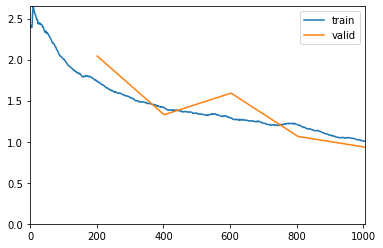

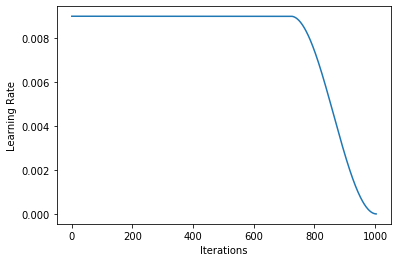

In [64]:
fcfit(learn,5,lr=.03)

fcfit: num_epochs: 15, lr = 0.004
Flat for 2170 epochs, then cosine anneal for 845


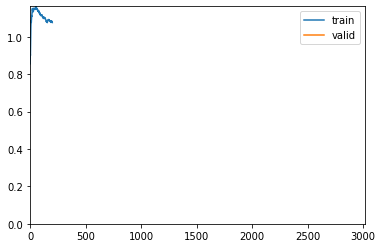

KeyboardInterrupt: 

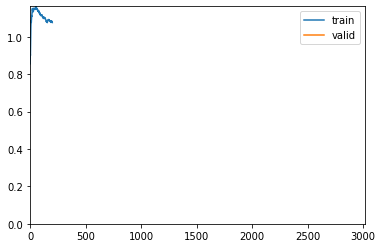

In [50]:
fcfit(learn,15,lr=.004)

fcfit: num_epochs: 5, lr = 0.0045
Flat for 723 epochs, then cosine anneal for 282
init and print of slow weights
2


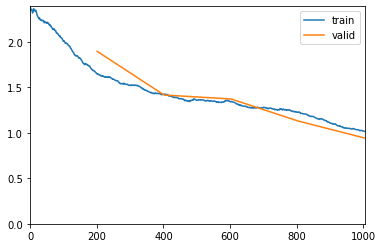

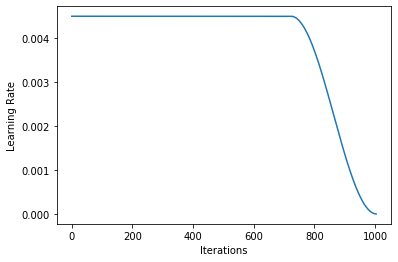

In [27]:
fcfit(learn,5,lr=.0045)

fcfit: num_epochs: 5, lr = 0.004
Flat for 698 epochs, then cosine anneal for 272
init and print of slow weights
2


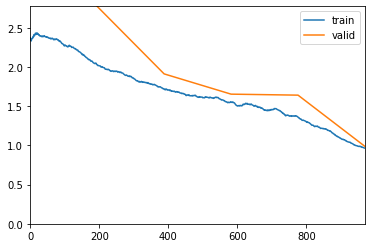

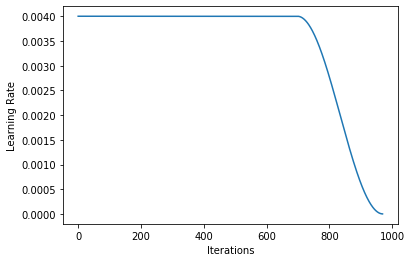

In [24]:
fcfit(learn,5,lr=.004)

fcfit: num_epochs: 5, lr = 0.003
Flat for 698 epochs, then cosine anneal for 272
init and print of slow weights
2


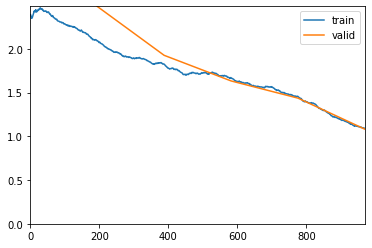

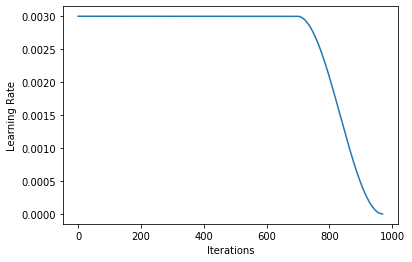

In [17]:
fcfit(learn,5,lr=.003)

fcfit: num_epochs: 20, lr = 0.004
Flat for 2793 epochs, then cosine anneal for 1087
init and print of slow weights
2


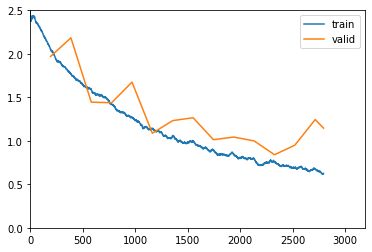

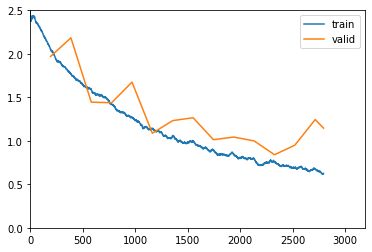

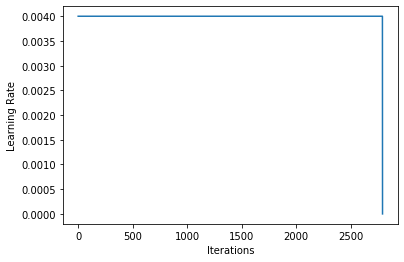

In [27]:
fcfit(learn,20,lr=.004)

fcfit: num_epochs: 5, lr = 0.004
Flat for 698 epochs, then cosine anneal for 272
init and print of slow weights
2


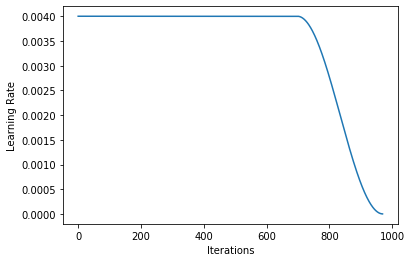

In [22]:
fcfit(learn,5,lr=.004)

fcfit: num_epochs: 5, lr = 0.004
Flat for 698 epochs, then cosine anneal for 272
init and print of slow weights
2


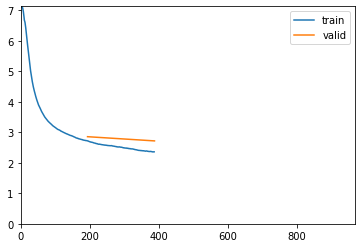

KeyboardInterrupt: 

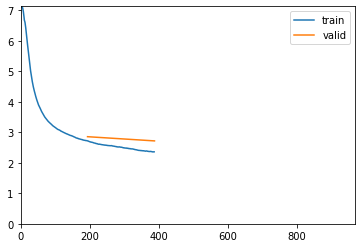

In [18]:
fcfit(learn,5,lr=.004)

fcfit: num_epochs: 5, lr = 0.004
Flat for 698 epochs, then cosine anneal for 272


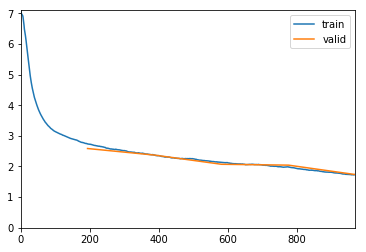

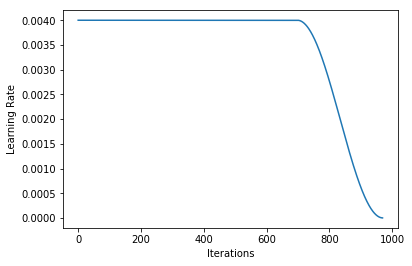

In [16]:
fcfit(learn,5,lr=.004)

fcfit: num_epochs: 5, lr = 0.004
Flat for 698 epochs, then cosine anneal for 272


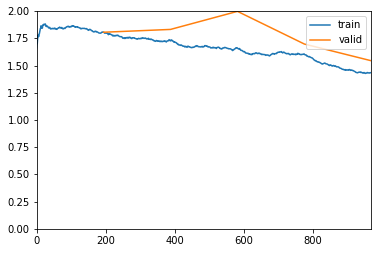

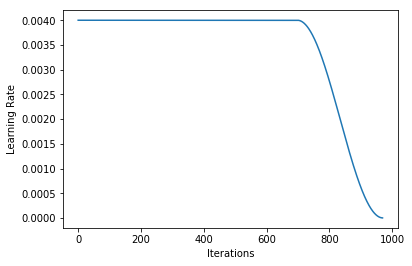

In [17]:
fcfit(learn,5,lr=.004) #test from load, old code

In [21]:
fcfit(learn,5,lr=.004) #test old ranger with debug

fcfit: num_epochs: 5, lr = 0.004
Flat for 698 epochs, then cosine anneal for 272


KeyError: 'k'

In [23]:
learn.save('test1')

In [22]:
learn.load('test2')

set state called


Learner(data=ImageDataBunch;

Train: LabelList (12454 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
n02093754,n02093754,n02093754,n02093754,n02093754
Path: /home/ubuntu/.fastai/data/imagewoof;

Valid: LabelList (500 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
n02093754,n02093754,n02093754,n02093754,n02093754
Path: /home/ubuntu/.fastai/data/imagewoof;

Test: None, model=MXResNet(
  (0): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Mish()
  )
  (1): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Mish()
  )
  (2): 

fcfit: num_epochs: 4, lr = 0.004
Flat for 558 epochs, then cosine anneal for 218


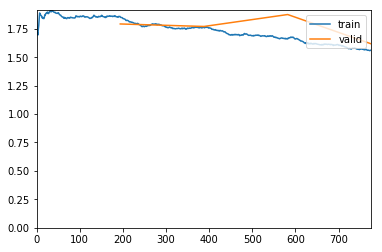

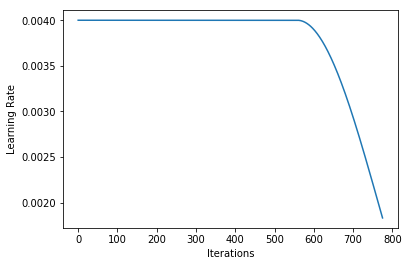

In [23]:
fcfit(learn,4,lr=.004) #test from load

fcfit: num_epochs: 5, lr = 0.004
Flat for 698 epochs, then cosine anneal for 272


Initializing slow buffer...should not see this at load from saved model!


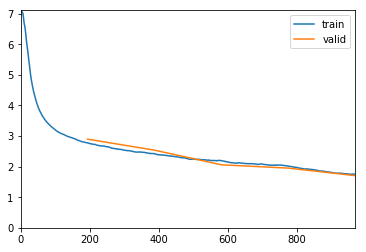

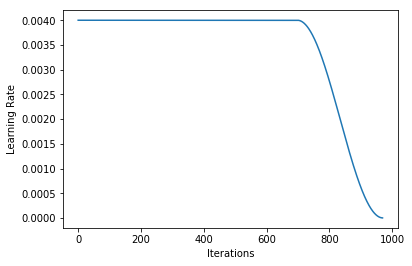

In [16]:
fcfit(learn,5,lr=.004)

fcfit: num_epochs: 5, lr = 0.004
Flat for 698 epochs, then cosine anneal for 272


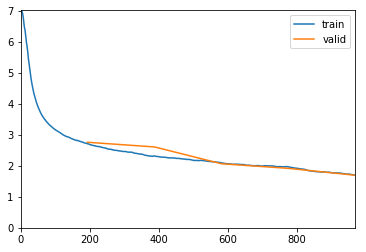

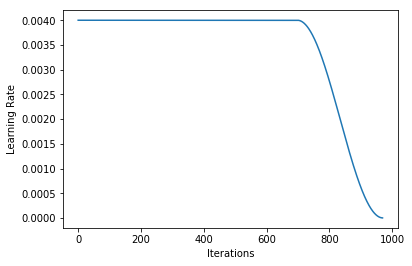

In [22]:
fcfit(learn,5,lr=.004)

In [17]:
learn.save('test2')

In [ ]:
learn.load('test2')

fcfit: num_epochs: 5, lr = 0.004
Flat for 698 epochs, then cosine anneal for 272
group step counter init
group step counter init


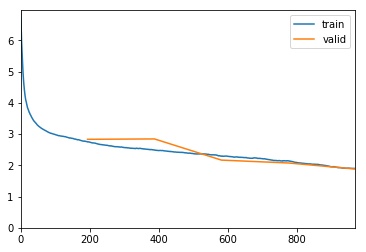

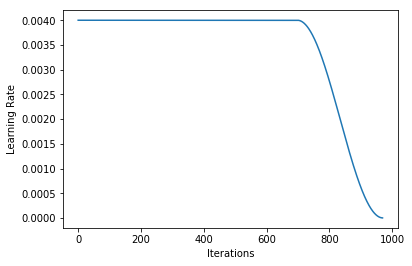

In [21]:
fcfit(learn,5,lr=.004) #rangeradam

fcfit: num_epochs: 5, lr = 0.004
Flat for 698 epochs, then cosine anneal for 272
group step counter init
group step counter init


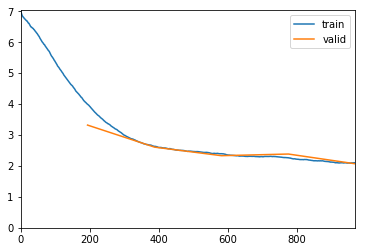

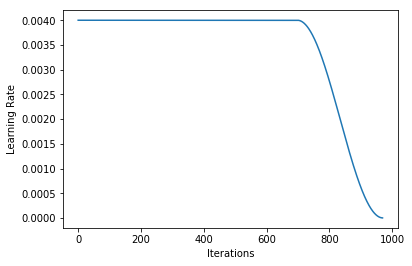

In [16]:
fcfit(learn,5,lr=.004) #correct rangerlamb

fcfit: num_epochs: 5, lr = 0.005
Flat for 698 epochs, then cosine anneal for 272


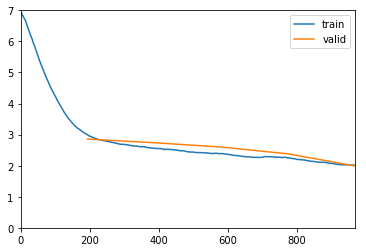

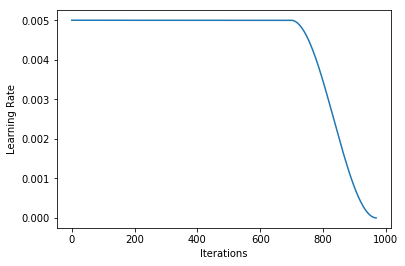

In [51]:
fcfit(learn,5,lr=.005)

fcfit: num_epochs: 5, lr = 0.004
Flat for 698 epochs, then cosine anneal for 272


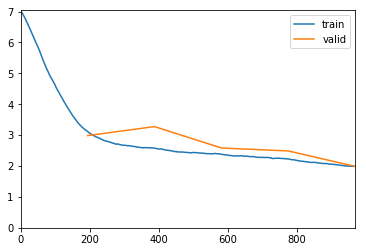

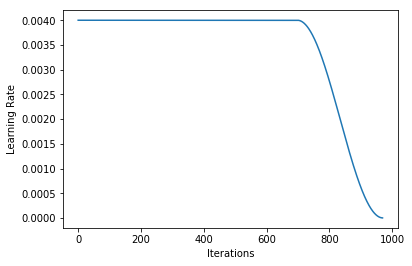

In [42]:
fcfit(learn,5,lr=.004) #RangerLamb

fcfit: num_epochs: 5, lr = 0.004
Flat for 698 epochs, then cosine anneal for 272


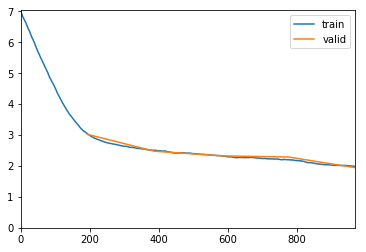

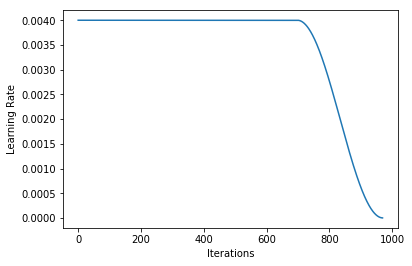

In [17]:
fcfit(learn,5,lr=.004) #lamb

fcfit: num_epochs: 5, lr = 0.004
Flat for 698 epochs, then cosine anneal for 272


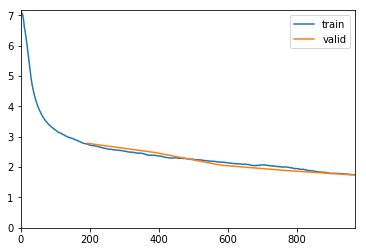

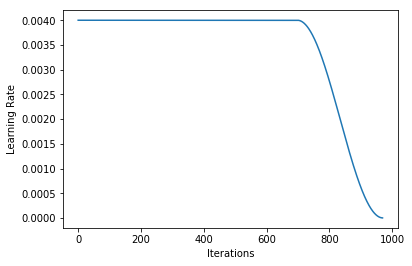

In [70]:
fcfit(learn,5,lr=.004)

fcfit: num_epochs: 5, lr = 0.004
Flat for 698 epochs, then cosine anneal for 272


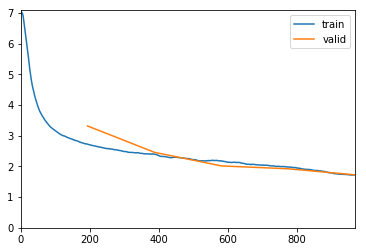

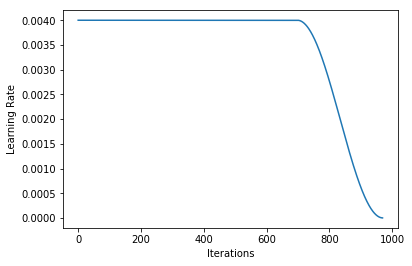

In [62]:
fcfit(learn,5,lr=.004)

fcfit: num_epochs: 5, lr = 0.004
Flat for 698 epochs, then cosine anneal for 272


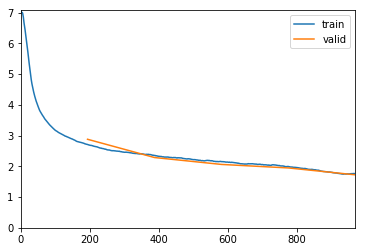

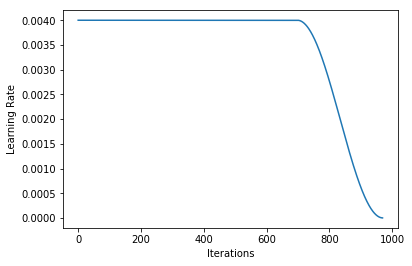

In [49]:
fcfit(learn,5,lr=.004) #contrast

fcfit: num_epochs: 5, lr = 0.004
Flat for 698 epochs, then cosine anneal for 272


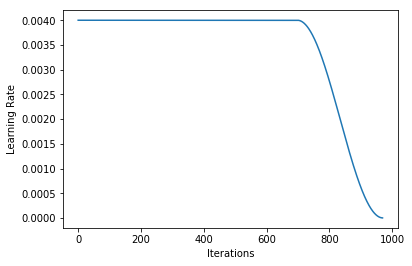

In [40]:
fcfit(learn,5,lr=.004)

fcfit: num_epochs: 5, lr = 0.00415
Flat for 698 epochs, then cosine anneal for 272


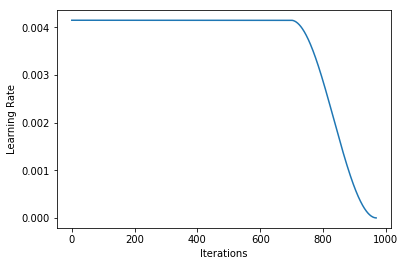

In [32]:
fcfit(learn,5,lr=.00415)

fcfit: num_epochs: 5, lr = 0.00415
Flat for 698 epochs, then cosine anneal for 272
init of slow weights
after init of slow weights
[[tensor([[[[ 3.0943e-02,  1.5705e-01, -1.8327e-01],
          [-6.0497e-02,  2.3699e-01,  1.9174e-01],
          [-1.6648e-01,  8.5943e-02, -2.3979e-01]],

         [[ 1.8259e-01,  3.7909e-01, -5.6277e-02],
          [-3.2191e-01,  5.2749e-01,  1.8099e-01],
          [-3.6363e-02,  2.7495e-01,  8.1760e-02]],

         [[-4.5887e-01,  3.8368e-01, -1.3858e-01],
          [ 1.1019e-01, -2.0498e-01, -3.3267e-01],
          [-5.3663e-02,  1.2979e-01, -2.2083e-02]]],


        [[[ 3.4535e-01,  3.1050e-01, -2.4584e-01],
          [ 3.8906e-02, -1.8997e-01,  1.8634e-01],
          [-4.0634e-01,  2.4084e-02, -2.6899e-02]],

         [[ 1.7403e-01, -6.2728e-02,  2.2418e-01],
          [-2.9210e-01, -1.8304e-01, -3.7675e-01],
          [ 1.6684e-01,  1.2236e-01,  6.7544e-02]],

         [[ 2.0024e-01, -8.1916e-02,  2.9742e-02],
          [ 3.2291e-01,  1.7195e-01,  4

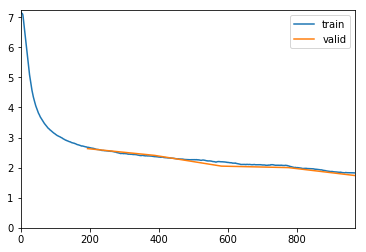

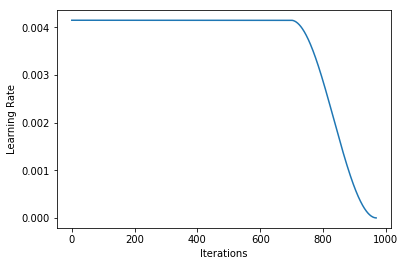

In [16]:
fcfit(learn,5,lr=.00415)

In [19]:
learn.opt.check_weights

AttributeError: 'Learner' object has no attribute 'opt'

In [26]:
class FlatCosAnnealScheduler(LearnerCallback):
  """
  Manage FCFit training as found in the ImageNette experiments
  https://forums.fast.ai/t/how-we-beat-the-5-epoch-imagewoof-leaderboard-score-some-new-techniques-to-consider/53453
  Based on idea by Mikhail Grankin
  """
  def __init__(self, learn:Learner, lr:float=4e-3, moms:Floats=(0.95,0.999),
             start_pct:float=0.72, start_epoch:int=1, tot_epochs:int=1,
              curve='cosine'):
      super().__init__(learn)
      n = len(learn.data.train_dl)
      self.start_epoch, self.tot_epochs = start_epoch, tot_epochs
      self.anneal_start = int(n * self.tot_epochs * start_pct)
      self.batch_finish = (n * self.tot_epochs - self.anneal_start)
      if curve=="cosine":
          curve_type=annealing_cos
      elif curve=="linear":
          curve_type=annealing_linear
      elif curve=="exponential":
          curve_type=annealing_exp
      else:
          raiseValueError(f"annealing type not supported {curve}")
      phase0 = TrainingPhase(self.anneal_start).schedule_hp('lr', lr).schedule_hp('mom', moms[0])
      phase1 = TrainingPhase(self.batch_finish).schedule_hp('lr', lr, anneal=curve_type).schedule_hp('mom', moms[1])
      phases = [phase0, phase1]
      sched = GeneralScheduler(learn, phases)
      self.learn.callbacks.append(sched)

In [20]:
FlatCosAnnealScheduler(learn,1)

TypeError: unsupported operand type(s) for *: 'int' and 'NoneType'

fcfit: num_epochs: 5, lr = 0.00415
Flat for 698 epochs, then cosine anneal for 272
init of slow weights
after init of slow weights
[[tensor([[[[ 2.9639e-01,  1.1589e-01,  3.1417e-01],
          [ 9.0810e-02, -4.8321e-01, -1.0272e-01],
          [ 1.4891e-01, -3.9165e-01,  3.2626e-01]],

         [[-9.3527e-02, -4.6904e-01,  3.5350e-01],
          [ 9.2024e-02, -1.1503e-01,  1.8314e-01],
          [-1.5241e-01,  4.6130e-01, -4.2538e-02]],

         [[-3.8026e-02, -6.3196e-01,  1.2342e-01],
          [ 1.2428e-01,  1.9279e-01,  1.2832e-01],
          [ 3.0869e-01, -7.1355e-02,  3.4177e-02]]],


        [[[ 1.1434e-01, -1.9415e-01, -2.1984e-01],
          [ 6.2527e-03, -4.5483e-02, -1.2208e-01],
          [ 1.8885e-01,  6.2640e-02,  1.8148e-01]],

         [[ 1.6174e-01,  1.8919e-02, -1.4859e-01],
          [-2.6659e-01,  3.3272e-01, -2.7458e-01],
          [-7.1773e-02, -3.4607e-03, -3.3285e-01]],

         [[ 3.7877e-01, -9.1114e-02,  1.5868e-01],
          [ 2.3589e-01,  1.6935e-01,  2

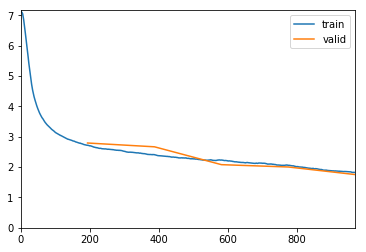

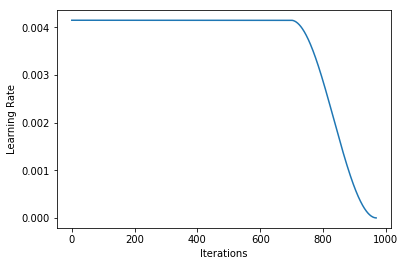

In [24]:
fcfit(learn,5,lr=.00415)

fcfit: num_epochs: 5, lr = 0.00415
Flat for 698 epochs, then cosine anneal for 272


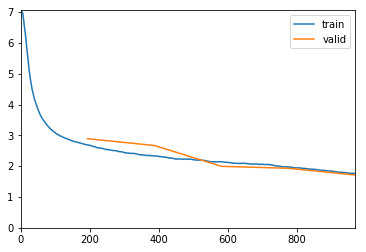

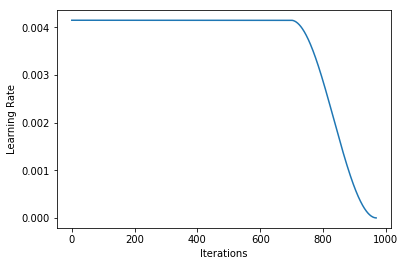

In [16]:
fcfit(learn,5,lr=.00415)

fcfit: num_epochs: 5, lr = 0.00415
Flat for 698 epochs, then cosine anneal for 272


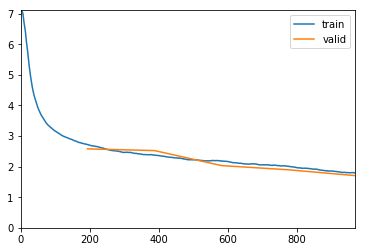

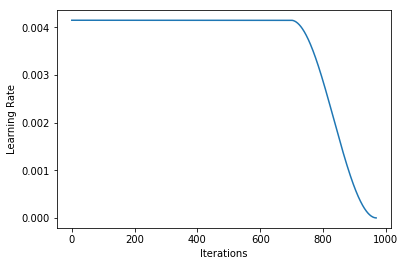

In [35]:
fcfit(learn,5,lr=.00415)

fcfit: num_epochs: 5, lr = 0.00425
Flat for 698 epochs, then cosine anneal for 272


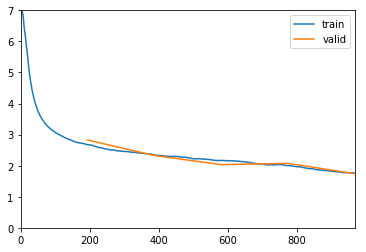

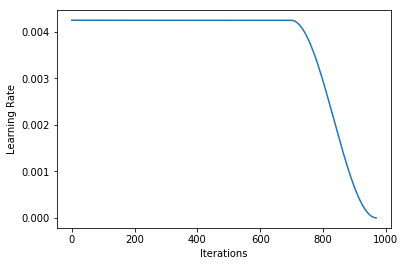

In [30]:
fcfit(learn,5,lr=.00425)

fcfit: num_epochs: 5, lr = 0.0045
Flat for 698 epochs, then cosine anneal for 272


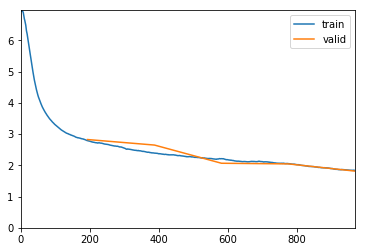

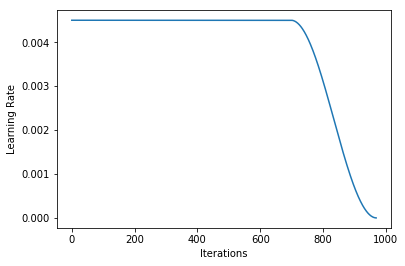

In [25]:
fcfit(learn,5,lr=.0045)

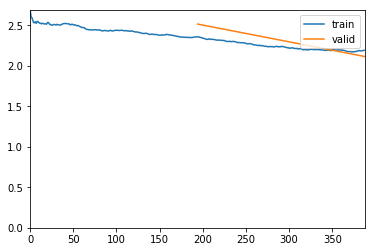

In [25]:
learn.fit(2,lr=.0035)

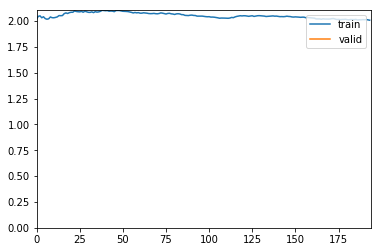

In [26]:
learn.fit(1,lr=.003)

In [ ]:
learn.fit(2,lr=.0025)

Using Ranger Optimizer...


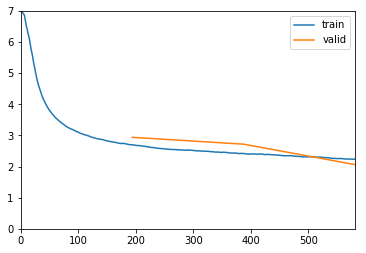

In [33]:
learn.fit(3,lr=.004)

Using Ranger Optimizer...


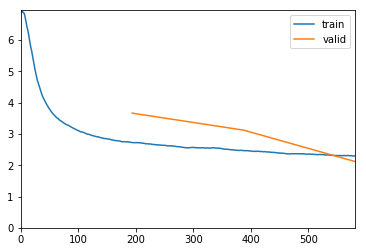

In [25]:
learn.fit(3,lr=.004)

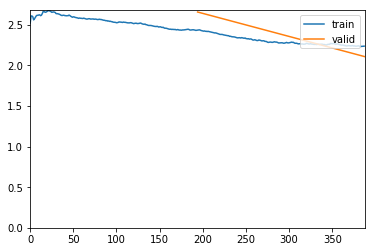

In [16]:
learn.fit(2,lr=.004)

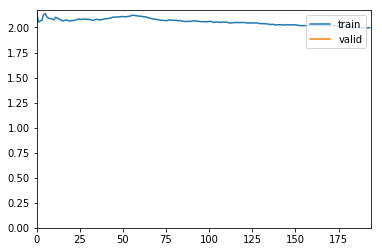

In [17]:
learn.fit(1,lr=.002)

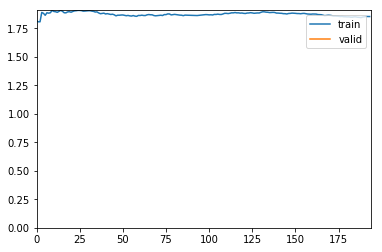

In [18]:
learn.fit(1,lr=.001)

Using Ranger Optimizer...


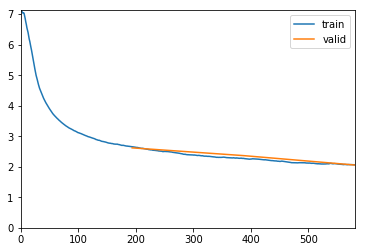

In [146]:
learn.fit(3,lr=.004) #.95

Using Ranger Optimizer...


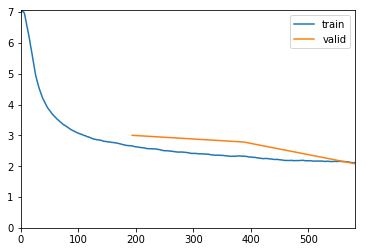

In [133]:
learn.fit(3,lr=.004) #.85

Using Ranger Optimizer...


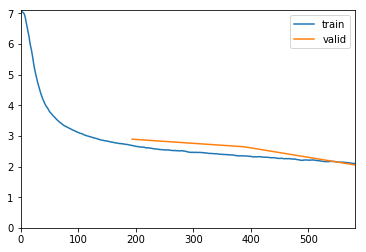

In [125]:
learn.fit(3,lr=.004) #.8

Using Ranger Optimizer...


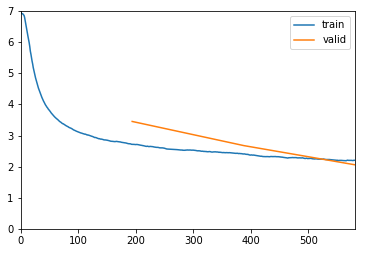

In [117]:
learn.fit(3,lr=.004) #.7

Using Ranger Optimizer...


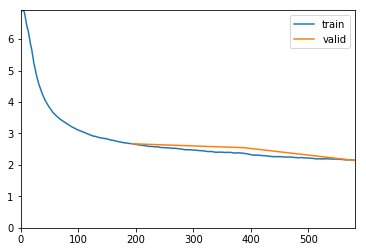

In [96]:
learn.fit(3,lr=.004)

In [78]:
learn.opt_func=optar2

fcfit: num_epochs: 2, lr = 0.004
Flat for 155 epochs, then cosine anneal for 233


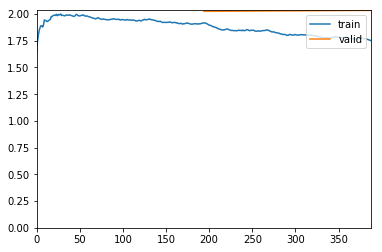

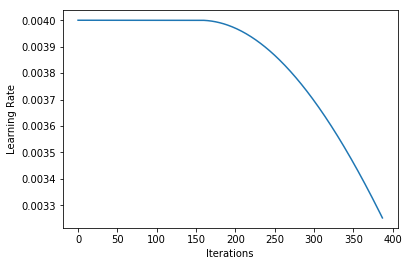

In [80]:
fcfit(learn,2,lr=.004,start_pct=.4)

Using Ranger Optimizer...


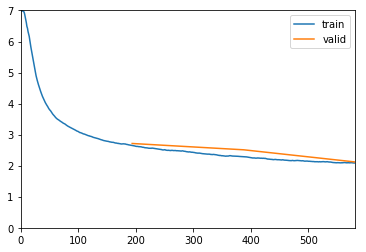

In [76]:
learn.fit(3,lr=.004)

Using Ranger Optimizer...


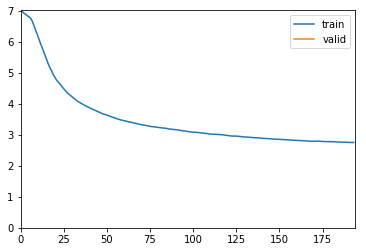

In [61]:
learn.fit(1,lr=.01)

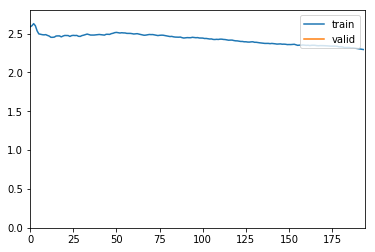

In [53]:
learn.fit(1,lr=.006)

set state called
LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


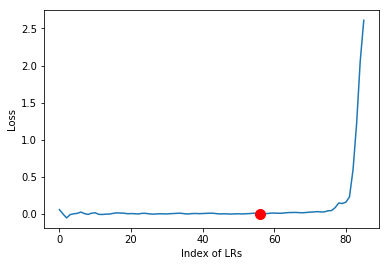

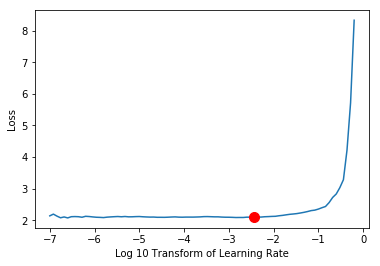

0.00363078054770101

In [54]:
findlr(learn,lr_diff=20)

In [17]:
def findlr(model:Learner, lr_diff:int = 5, loss_threshold:float = .05, adjust_value:float = 1, plot:bool = True) -> float:
    #Run the Learning Rate Finder
    model.lr_find()
    
    #Get loss values and their corresponding gradients, and get lr values
    losses = np.array(model.recorder.losses)
    assert(lr_diff < len(losses))
    loss_grad = np.gradient(losses)
    lrs = model.recorder.lrs
    
    #Search for index in gradients where loss is lowest before the loss spike
    #Initialize right and left idx using the lr_diff as a spacing unit
    #Set the local min lr as -1 to signify if threshold is too low
    r_idx = -1
    l_idx = r_idx - lr_diff
    while (l_idx >= -len(losses)) and (abs(loss_grad[r_idx] - loss_grad[l_idx]) > loss_threshold):
        local_min_lr = lrs[l_idx]
        r_idx -= 1
        l_idx -= 1

    lr_to_use = local_min_lr * adjust_value
    
    if plot:
        # plots the gradients of the losses in respect to the learning rate change
        plt.plot(loss_grad)
        plt.plot(len(losses)+l_idx, loss_grad[l_idx],markersize=10,marker='o',color='red')
        plt.ylabel("Loss")
        plt.xlabel("Index of LRs")
        plt.show()

        plt.plot(np.log10(lrs), losses)
        plt.ylabel("Loss")
        plt.xlabel("Log 10 Transform of Learning Rate")
        loss_coord = np.interp(np.log10(lr_to_use), np.log10(lrs), losses)
        plt.plot(np.log10(lr_to_use), loss_coord, markersize=10,marker='o',color='red')
        plt.show()
        
    return lr_to_use


Using Ranger Optimizer...


set state called
LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


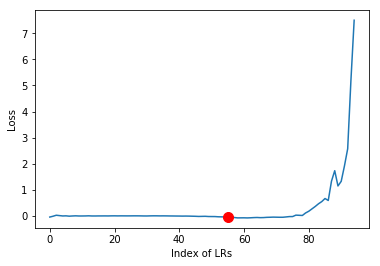

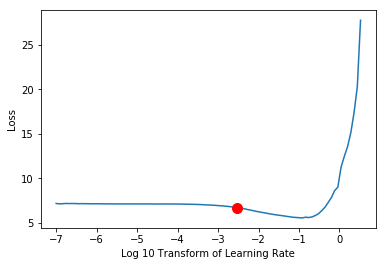

0.0030199517204020187

In [31]:
findlr(learn, lr_diff=20)

In [21]:
print(4e-3)

0.004


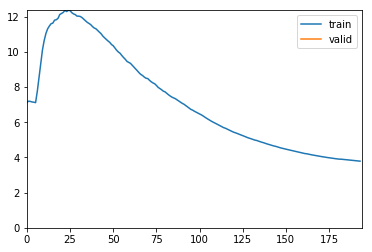

In [33]:
learn.fit(1,lr=.003)

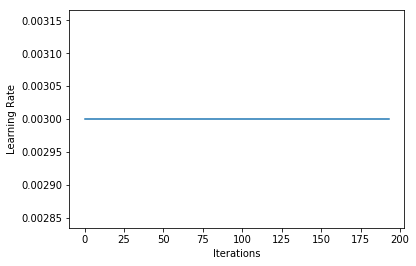

In [34]:
learn.recorder.plot_lr()

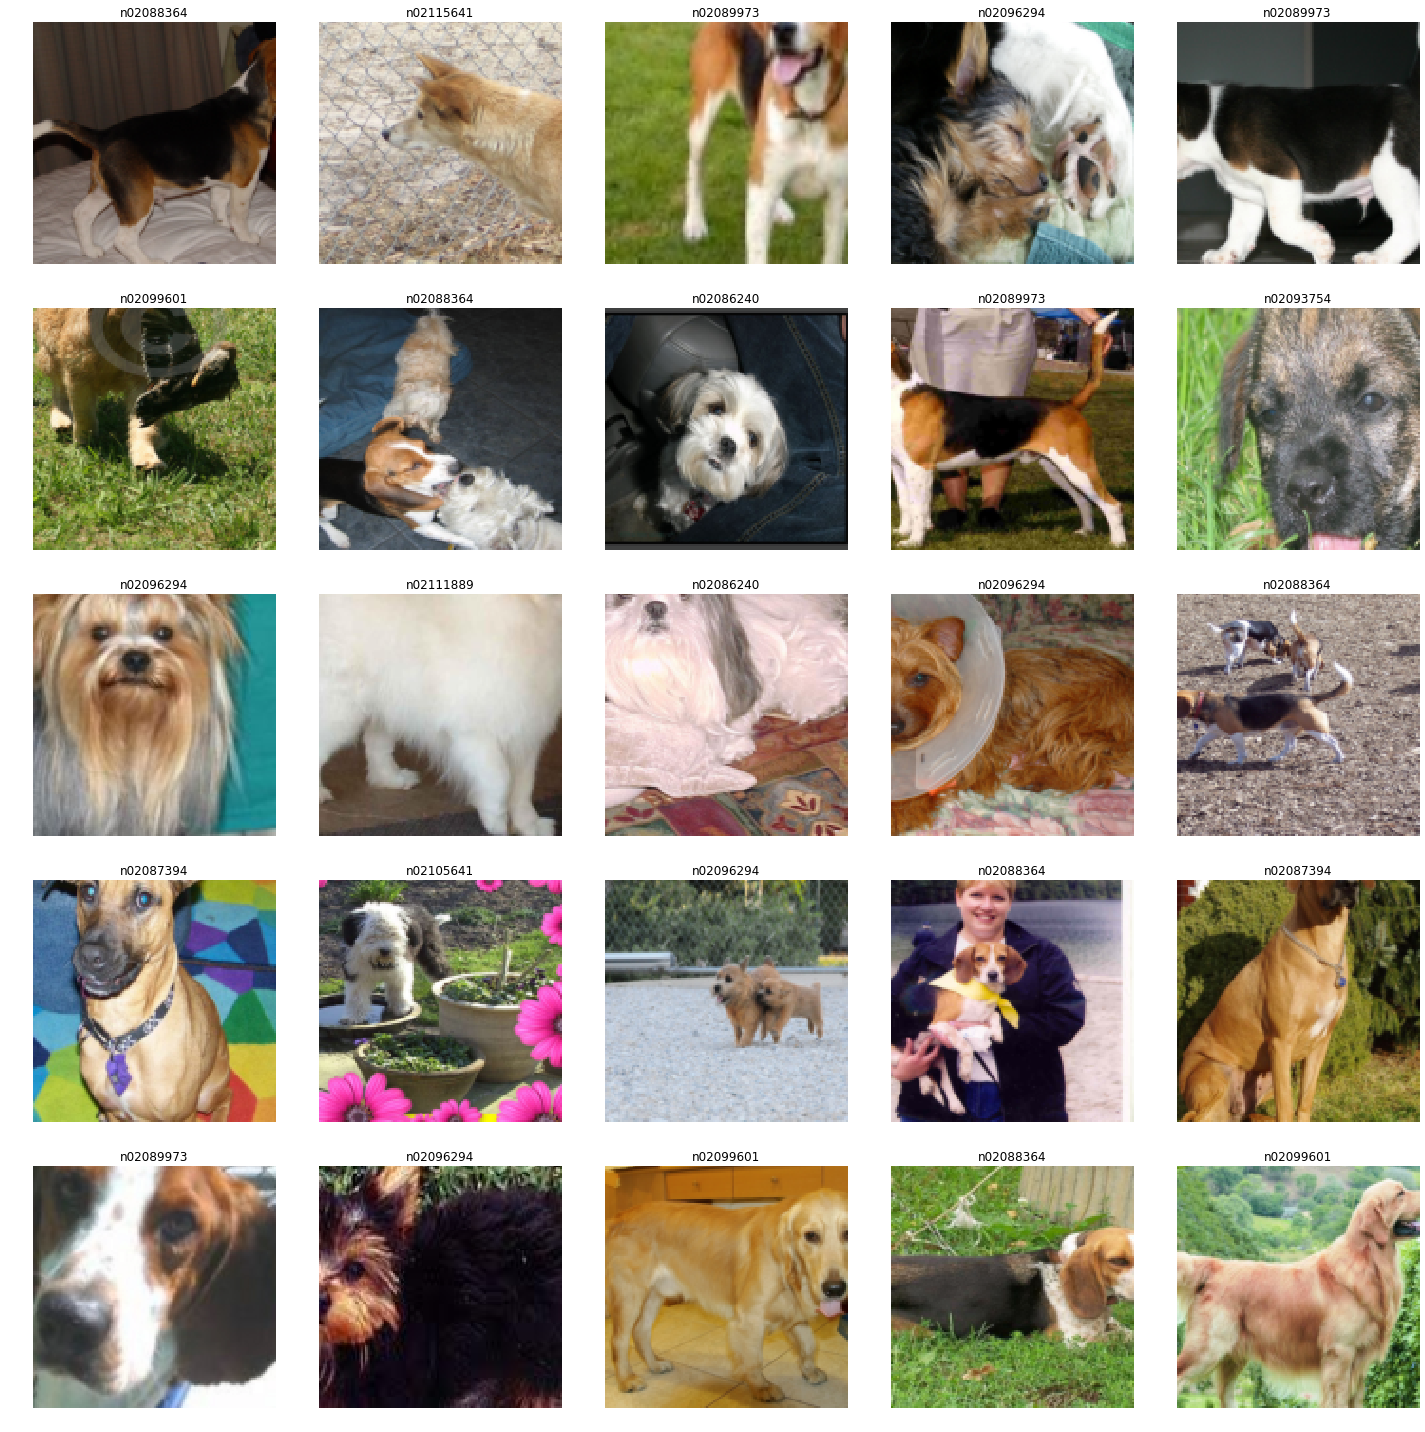

In [21]:
data.show_batch()

set state called
LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


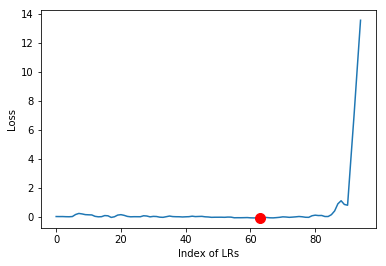

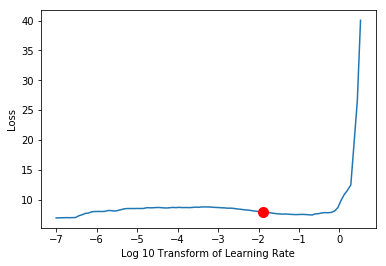

0.013182567385564075

In [27]:
findlr(learn, lr_diff=15)

set state called
LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


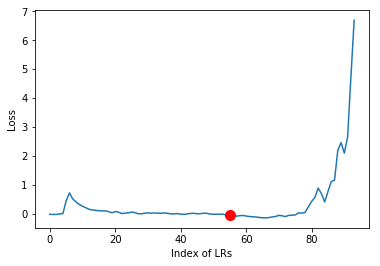

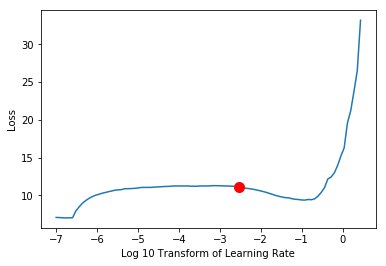

0.0030199517204020187

In [28]:
findlr(learn, lr_diff=20)

set state called
LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


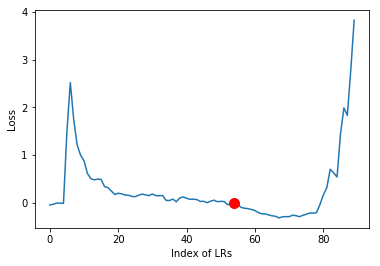

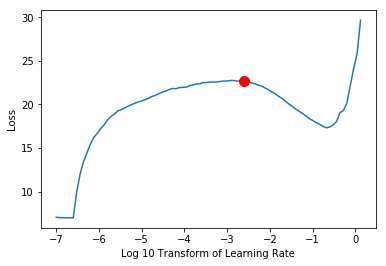

0.002511886431509582

In [29]:
findlr(learn, lr_diff=22)

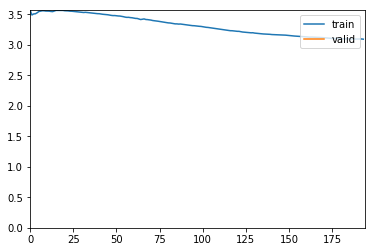

In [32]:
learn.fit_one_cycle(1,max_lr=4e-3)

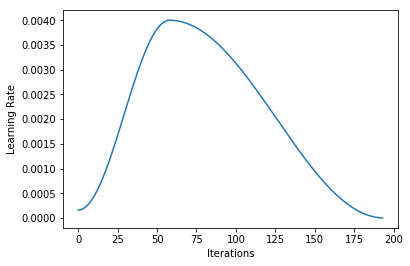

In [33]:
learn.recorder.plot_lr()

In [34]:
learn.save('test1')

In [35]:
learn.load('test1')

set state called


Learner(data=ImageDataBunch;

Train: LabelList (12454 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
n02093754,n02093754,n02093754,n02093754,n02093754
Path: /home/ubuntu/.fastai/data/imagewoof;

Valid: LabelList (500 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
n02093754,n02093754,n02093754,n02093754,n02093754
Path: /home/ubuntu/.fastai/data/imagewoof;

Test: None, model=MXResNet(
  (0): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Mish()
  )
  (1): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Mish()
  )
  (2): 

Using Ranger Optimizer...


set state called
LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


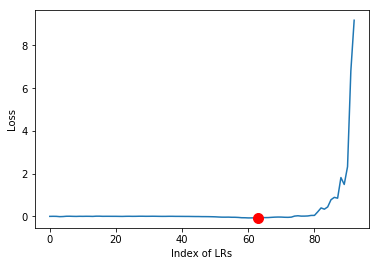

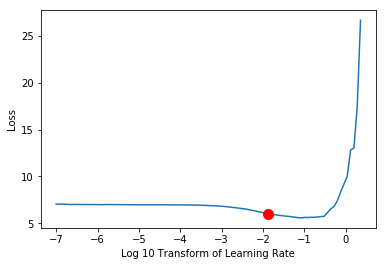

0.013182567385564075

In [26]:
findlr(learn, lr_diff=10)

Using Ranger Optimizer...


set state called
LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


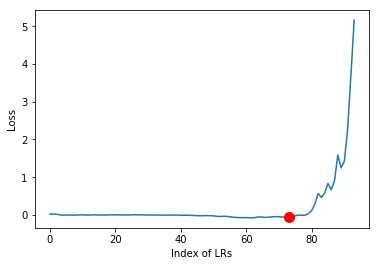

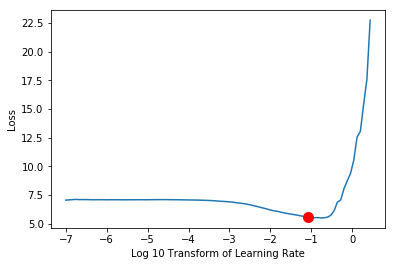

0.08317637711026708

In [16]:
findlr(learn, lr_diff=10)

fcfit: num_epochs: 5, lr = 0.08
Flat for 698 epochs, then cosine anneal for 272


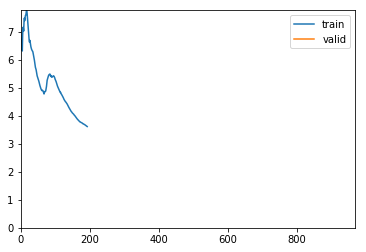

KeyboardInterrupt: 

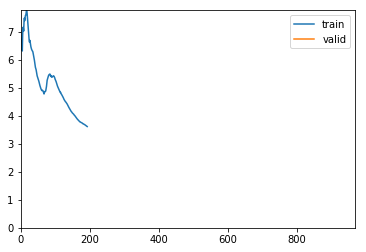

In [19]:
fcfit(learn,5,lr=0.08)

fcfit: num_epochs: 5, lr = 0.0043
Flat for 698 epochs, then cosine anneal for 272
Using Ranger Optimizer...


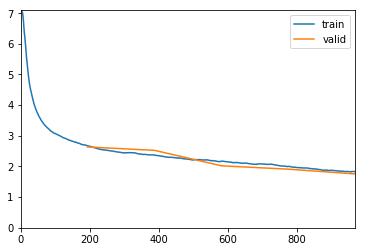

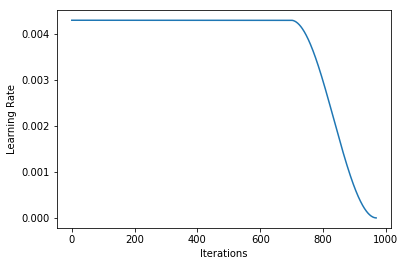

In [61]:
fcfit(learn,5,lr=0.0043)

fcfit: num_epochs: 5, lr = 0.004
Flat for 698 epochs, then cosine anneal for 272
Using Ranger Optimizer...


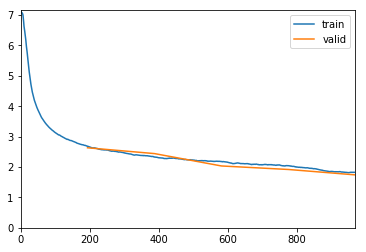

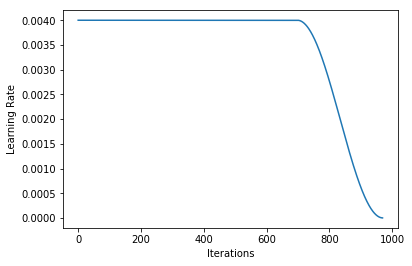

In [53]:
fcfit(learn,5,lr=0.004)

fcfit: num_epochs: 5, lr = 0.00375
Flat for 698 epochs, then cosine anneal for 272


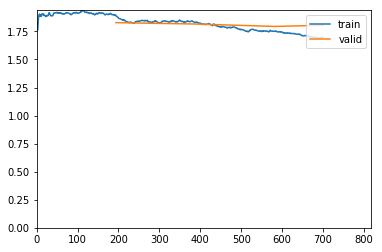

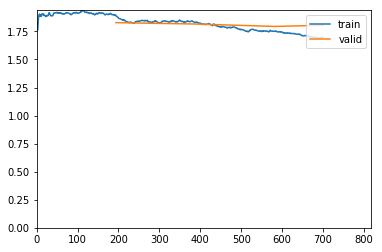

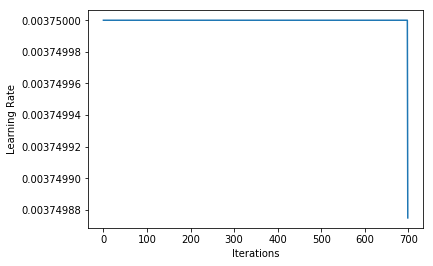

In [54]:
fcfit(learn,5,lr=0.00375)

fcfit: num_epochs: 5, lr = 0.004
Flat for 698 epochs, then cosine anneal for 272
Using Ranger Optimizer...


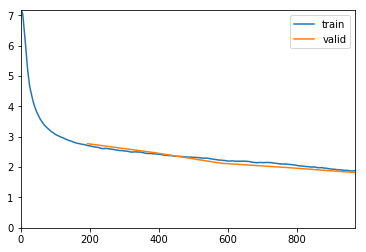

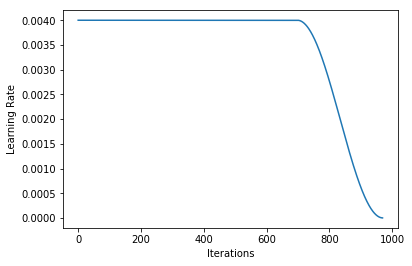

In [38]:
fcfit(learn,5,lr=0.004)

fcfit: num_epochs: 5, lr = 0.005
Flat for 698 epochs, then cosine anneal for 272
Using Ranger Optimizer...


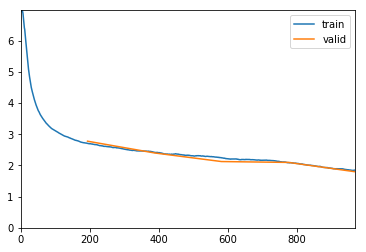

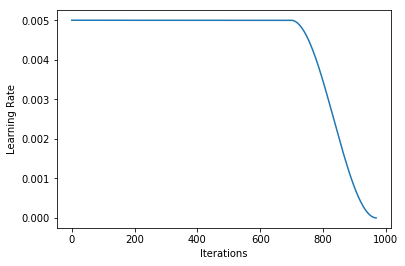

In [31]:
fcfit(learn,5,lr=0.005)

set state called
LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


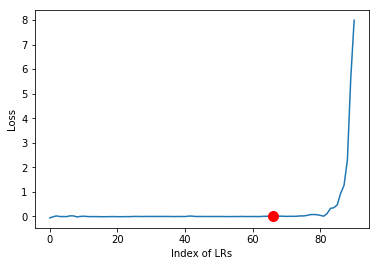

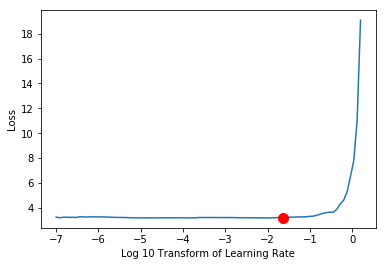

0.022908676527677745

In [21]:
findlr(learn)

fcfit: num_epochs: 1, lr = 0.022908676527677745
Flat for 139 epochs, then cosine anneal for 55


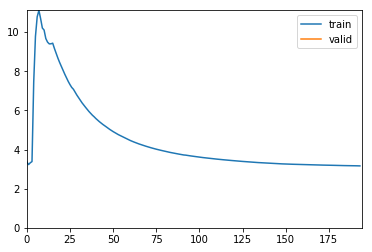

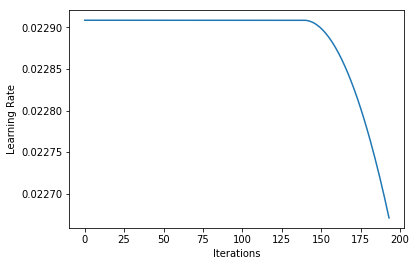

In [22]:
fcfit(learn,1,lr=0.022908676527677745)

set state called
LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


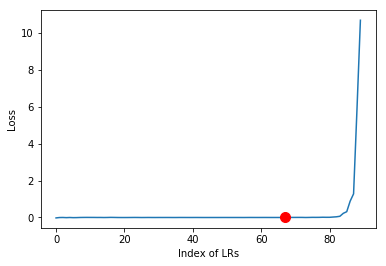

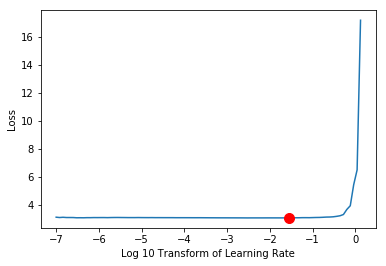

0.027542287033381692

In [23]:
findlr(learn)

fcfit: num_epochs: 1, lr = 0.027542287033381692
Flat for 139 epochs, then cosine anneal for 55


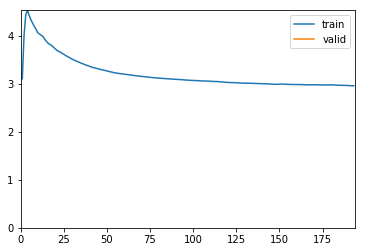

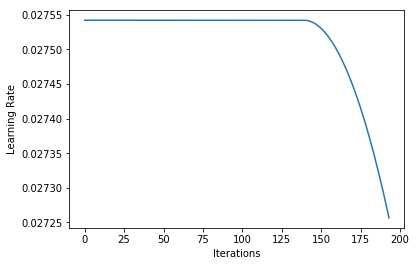

In [24]:
fcfit(learn,lr=0.027542287033381692)

In [ ]:
findlr(learn)

In [ ]:
fcfit(learn,lr=)

In [ ]:
def fit_fc(learn:Learner, cyc_len:int, lr:float=defaults.lr,
                  moms:Tuple[float,float]=(0.95,0.85), start_pct:float=0.72,
                  wd:float=None, callbacks:Optional[CallbackList]=None, tot_epochs:int=None, show_curve:bool=False)->None:
    

In [17]:
fcfit(learn,1)

Mila activation...
fcfit: num_epochs: 5, lr = 0.004
Flat for 698 epochs, then cosine anneal for 272


AttributeError: 'Mila' object has no attribute 'beta'

In [74]:
learn.mixup()

Learner(data=ImageDataBunch;

Train: LabelList (12454 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
n02093754,n02093754,n02093754,n02093754,n02093754
Path: /home/ubuntu/.fastai/data/imagewoof-160;

Valid: LabelList (500 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
n02093754,n02093754,n02093754,n02093754,n02093754
Path: /home/ubuntu/.fastai/data/imagewoof-160;

Test: None, model=XResNet(
  (0): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
  )
  (1): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU

In [48]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


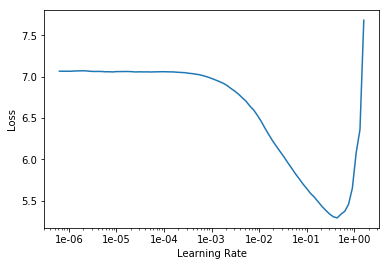

In [49]:
learn.recorder.plot()

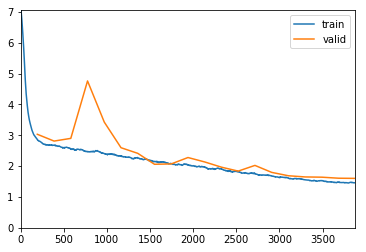

In [50]:
learn.fit_one_cycle(20, max_lr=5e-2)

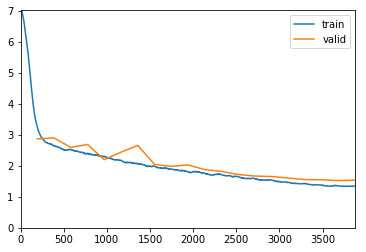

In [39]:
learn.fit_one_cycle(20, max_lr=8e-3)

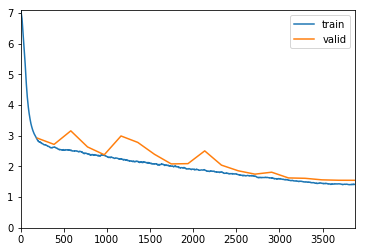

In [31]:
learn.fit_one_cycle(20, max_lr=3e-2)

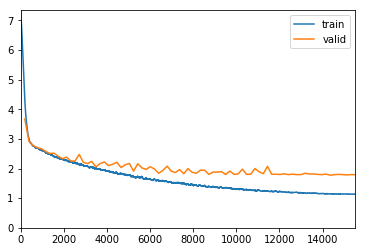

In [52]:
learn.fit_one_cycle(80, max_lr=8e-3)

Using AdamS optimizer...


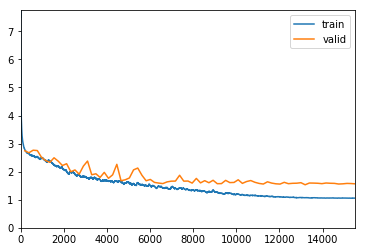

In [43]:
learn.fit_one_cycle(80, max_lr=1e-2) 

Novograd optimizer loaded...


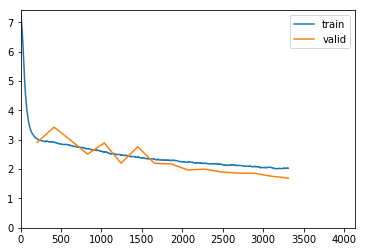

In [ ]:
learn.fit_one_cycle(20, max_lr=1e-1) #novo2

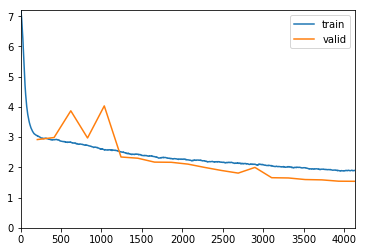

In [66]:
learn.fit_one_cycle(20, max_lr=3e-2)

Using AdamS optimizer...


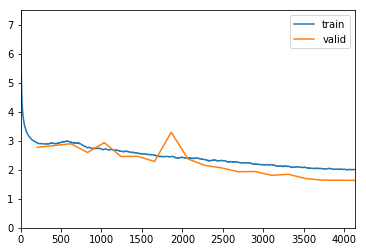

In [45]:
learn.fit_one_cycle(20,max_lr=2e-2)

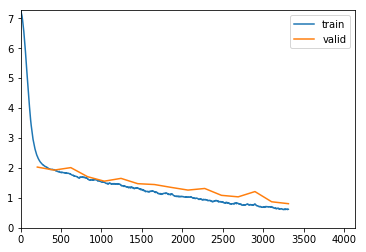

Better model found at epoch 0 with valid_loss value: 2.0284922122955322.
Better model found at epoch 1 with valid_loss value: 1.9272652864456177.
Better model found at epoch 3 with valid_loss value: 1.7075413465499878.
Better model found at epoch 4 with valid_loss value: 1.55732262134552.
Better model found at epoch 6 with valid_loss value: 1.473660945892334.
Better model found at epoch 7 with valid_loss value: 1.4452157020568848.
Better model found at epoch 8 with valid_loss value: 1.349548101425171.
Better model found at epoch 9 with valid_loss value: 1.2597721815109253.
Better model found at epoch 11 with valid_loss value: 1.084342122077942.
Better model found at epoch 12 with valid_loss value: 1.0340285301208496.
Better model found at epoch 14 with valid_loss value: 0.8691580891609192.
Better model found at epoch 15 with valid_loss value: 0.8056039810180664.


In [ ]:
learn.fit_one_cycle(20,max_lr=1e-2)

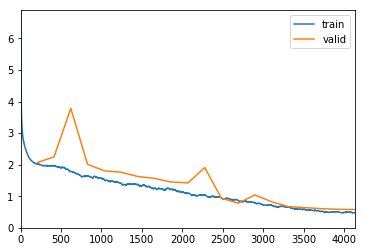

Better model found at epoch 0 with valid_loss value: 2.067270278930664.
Better model found at epoch 3 with valid_loss value: 2.011732578277588.
Better model found at epoch 4 with valid_loss value: 1.8062434196472168.
Better model found at epoch 5 with valid_loss value: 1.76030695438385.
Better model found at epoch 6 with valid_loss value: 1.6262898445129395.
Better model found at epoch 7 with valid_loss value: 1.56466805934906.
Better model found at epoch 8 with valid_loss value: 1.4504941701889038.
Better model found at epoch 9 with valid_loss value: 1.4238845109939575.
Better model found at epoch 11 with valid_loss value: 0.9350396990776062.
Better model found at epoch 12 with valid_loss value: 0.7806150913238525.
Better model found at epoch 15 with valid_loss value: 0.6696752309799194.
Better model found at epoch 16 with valid_loss value: 0.6390795707702637.
Better model found at epoch 17 with valid_loss value: 0.6055475473403931.
Better model found at epoch 18 with valid_loss value

In [89]:
learn.fit_one_cycle(20,max_lr=1e-2)

Using Ranger-AdamS optimizer...


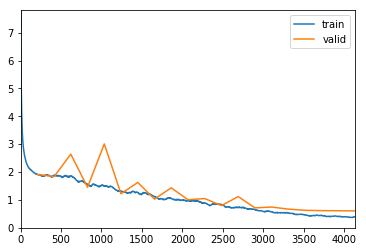

Better model found at epoch 0 with valid_loss value: 1.9178121089935303.
Better model found at epoch 1 with valid_loss value: 1.8345173597335815.
Better model found at epoch 3 with valid_loss value: 1.452370285987854.
Better model found at epoch 5 with valid_loss value: 1.2207589149475098.
Better model found at epoch 7 with valid_loss value: 1.028414249420166.
Better model found at epoch 9 with valid_loss value: 1.0062106847763062.
Better model found at epoch 11 with valid_loss value: 0.7972031235694885.
Better model found at epoch 13 with valid_loss value: 0.7151119709014893.
Better model found at epoch 15 with valid_loss value: 0.66959148645401.
Better model found at epoch 16 with valid_loss value: 0.6278588175773621.
Better model found at epoch 17 with valid_loss value: 0.6154802441596985.
Better model found at epoch 18 with valid_loss value: 0.6111466288566589.
Better model found at epoch 19 with valid_loss value: 0.6071603298187256.


In [80]:
learn.fit_one_cycle(20,max_lr=3e-2)

Using AdamS optimizer...


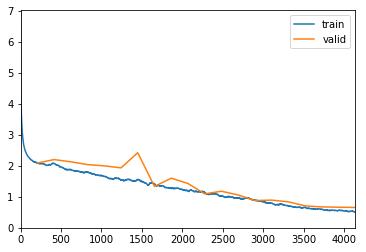

Better model found at epoch 0 with valid_loss value: 2.087594985961914.
Better model found at epoch 3 with valid_loss value: 2.038566827774048.
Better model found at epoch 4 with valid_loss value: 1.9975301027297974.
Better model found at epoch 5 with valid_loss value: 1.9319931268692017.
Better model found at epoch 7 with valid_loss value: 1.3329511880874634.
Better model found at epoch 10 with valid_loss value: 1.0944026708602905.
Better model found at epoch 12 with valid_loss value: 1.0585620403289795.
Better model found at epoch 13 with valid_loss value: 0.8801215887069702.
Better model found at epoch 15 with valid_loss value: 0.8372650146484375.
Better model found at epoch 16 with valid_loss value: 0.706852912902832.
Better model found at epoch 17 with valid_loss value: 0.6742544770240784.
Better model found at epoch 18 with valid_loss value: 0.6634275317192078.
Better model found at epoch 19 with valid_loss value: 0.6558474898338318.


In [62]:
learn.fit_one_cycle(20,max_lr=5e-2)

Using AdamS optimizer...


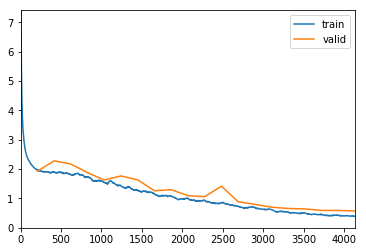

Better model found at epoch 0 with valid_loss value: 1.9272606372833252.
Better model found at epoch 3 with valid_loss value: 1.8765183687210083.
Better model found at epoch 4 with valid_loss value: 1.626479983329773.
Better model found at epoch 7 with valid_loss value: 1.2619565725326538.
Better model found at epoch 9 with valid_loss value: 1.0927274227142334.
Better model found at epoch 10 with valid_loss value: 1.0592094659805298.
Better model found at epoch 12 with valid_loss value: 0.8854070901870728.
Better model found at epoch 13 with valid_loss value: 0.7977852821350098.
Better model found at epoch 14 with valid_loss value: 0.7015910744667053.
Better model found at epoch 15 with valid_loss value: 0.6575521230697632.
Better model found at epoch 16 with valid_loss value: 0.6426635980606079.
Better model found at epoch 17 with valid_loss value: 0.5911067724227905.
Better model found at epoch 19 with valid_loss value: 0.5727702975273132.


In [55]:
learn.fit_one_cycle(20,max_lr=1e-2)

Using AdamS optimizer...


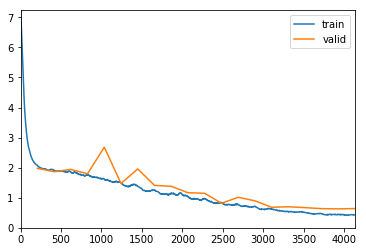

Better model found at epoch 0 with valid_loss value: 1.9785441160202026.
Better model found at epoch 1 with valid_loss value: 1.866024136543274.
Better model found at epoch 3 with valid_loss value: 1.7960745096206665.
Better model found at epoch 5 with valid_loss value: 1.4759739637374878.
Better model found at epoch 7 with valid_loss value: 1.4105552434921265.
Better model found at epoch 8 with valid_loss value: 1.3805943727493286.
Better model found at epoch 9 with valid_loss value: 1.1666226387023926.
Better model found at epoch 10 with valid_loss value: 1.1476881504058838.
Better model found at epoch 11 with valid_loss value: 0.8153693079948425.
Better model found at epoch 14 with valid_loss value: 0.6823706030845642.
Better model found at epoch 16 with valid_loss value: 0.6705621480941772.
Better model found at epoch 17 with valid_loss value: 0.6365214586257935.
Better model found at epoch 18 with valid_loss value: 0.6292324662208557.


In [38]:
learn.fit_one_cycle(20,max_lr=2e-3)

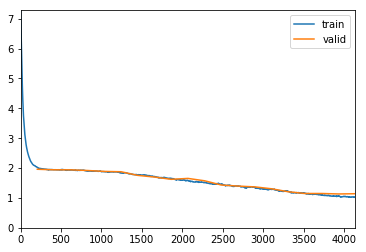

Better model found at epoch 0 with valid_loss value: 1.9603973627090454.
Better model found at epoch 1 with valid_loss value: 1.941968560218811.
Better model found at epoch 2 with valid_loss value: 1.9405126571655273.
Better model found at epoch 3 with valid_loss value: 1.9189997911453247.
Better model found at epoch 4 with valid_loss value: 1.88779878616333.
Better model found at epoch 5 with valid_loss value: 1.8772788047790527.
Better model found at epoch 6 with valid_loss value: 1.7550616264343262.
Better model found at epoch 7 with valid_loss value: 1.6992233991622925.
Better model found at epoch 8 with valid_loss value: 1.623336672782898.
Better model found at epoch 10 with valid_loss value: 1.5733678340911865.
Better model found at epoch 11 with valid_loss value: 1.4318701028823853.
Better model found at epoch 12 with valid_loss value: 1.3965166807174683.
Better model found at epoch 13 with valid_loss value: 1.3697476387023926.
Better model found at epoch 14 with valid_loss valu

In [30]:
learn.fit_one_cycle(20,max_lr=3e-3)

Using AutoLR Samurai!
max lr =  2
len of pg  2
0
0
count of groups with rgrad  167


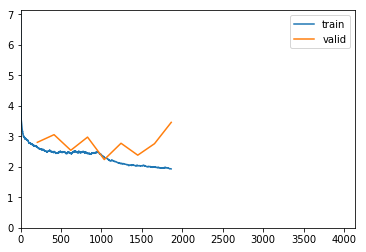

Better model found at epoch 0 with valid_loss value: 2.8024630546569824.
Better model found at epoch 2 with valid_loss value: 2.5414369106292725.
Better model found at epoch 4 with valid_loss value: 2.2378060817718506.


In [ ]:
learn.fit_one_cycle(20,max_lr=4)

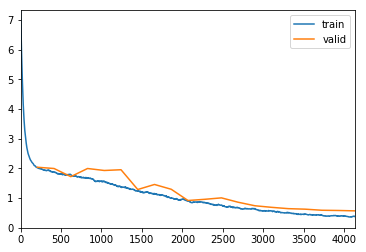

Better model found at epoch 0 with valid_loss value: 2.0381743907928467.
Better model found at epoch 1 with valid_loss value: 1.9961687326431274.
Better model found at epoch 2 with valid_loss value: 1.7219535112380981.
Better model found at epoch 6 with valid_loss value: 1.28867769241333.
Better model found at epoch 9 with valid_loss value: 0.9186249375343323.
Better model found at epoch 12 with valid_loss value: 0.8599935173988342.
Better model found at epoch 13 with valid_loss value: 0.7419646978378296.
Better model found at epoch 14 with valid_loss value: 0.6887533068656921.
Better model found at epoch 15 with valid_loss value: 0.6443329453468323.
Better model found at epoch 16 with valid_loss value: 0.6270418167114258.
Better model found at epoch 17 with valid_loss value: 0.5906723737716675.
Better model found at epoch 18 with valid_loss value: 0.5828292369842529.
Better model found at epoch 19 with valid_loss value: 0.5698525309562683.


In [34]:
learn.fit_one_cycle(20,max_lr=3e-3)

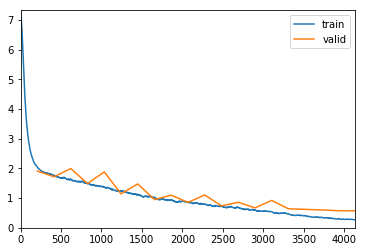

Better model found at epoch 0 with valid_loss value: 1.9079939126968384.
Better model found at epoch 1 with valid_loss value: 1.7196091413497925.
Better model found at epoch 3 with valid_loss value: 1.4896045923233032.
Better model found at epoch 5 with valid_loss value: 1.1426249742507935.
Better model found at epoch 7 with valid_loss value: 0.9503838419914246.
Better model found at epoch 9 with valid_loss value: 0.8554997444152832.
Better model found at epoch 11 with valid_loss value: 0.7397463321685791.
Better model found at epoch 13 with valid_loss value: 0.6704124212265015.
Better model found at epoch 15 with valid_loss value: 0.6412137746810913.
Better model found at epoch 16 with valid_loss value: 0.6201664805412292.
Better model found at epoch 17 with valid_loss value: 0.6015028357505798.
Better model found at epoch 18 with valid_loss value: 0.5754669904708862.
Better model found at epoch 19 with valid_loss value: 0.5715892314910889.


In [28]:
learn.fit_one_cycle(20,max_lr=5e-2)

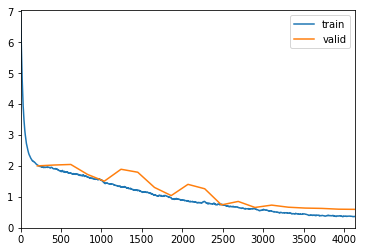

Better model found at epoch 0 with valid_loss value: 2.00215220451355.
Better model found at epoch 3 with valid_loss value: 1.726430892944336.
Better model found at epoch 4 with valid_loss value: 1.5070918798446655.
Better model found at epoch 7 with valid_loss value: 1.3050029277801514.
Better model found at epoch 8 with valid_loss value: 1.0421955585479736.
Better model found at epoch 11 with valid_loss value: 0.7405863404273987.
Better model found at epoch 13 with valid_loss value: 0.6580215692520142.
Better model found at epoch 16 with valid_loss value: 0.6379725337028503.
Better model found at epoch 17 with valid_loss value: 0.6272000670433044.
Better model found at epoch 18 with valid_loss value: 0.6018462777137756.
Better model found at epoch 19 with valid_loss value: 0.5963884592056274.


In [81]:
#learn.fit_one_cycle(20,max_lr=3e-3)

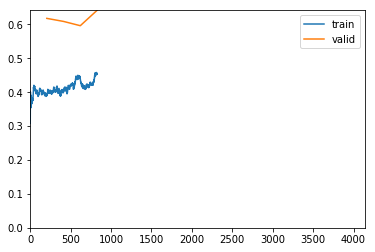

Better model found at epoch 0 with valid_loss value: 0.6176180243492126.
Better model found at epoch 1 with valid_loss value: 0.6086193919181824.
Better model found at epoch 2 with valid_loss value: 0.5960176587104797.


KeyboardInterrupt: 

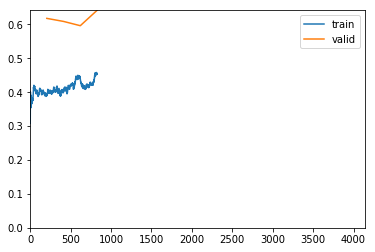

In [73]:
learn.fit_one_cycle(20,max_lr=3e-3)

Using Ranger Optimizer...


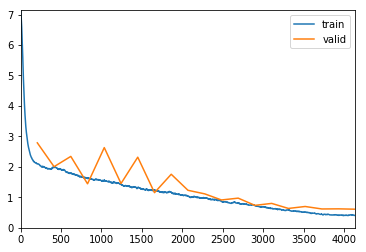

Better model found at epoch 0 with valid_loss value: 2.7892773151397705.
Better model found at epoch 1 with valid_loss value: 2.006809711456299.
Better model found at epoch 3 with valid_loss value: 1.4443359375.
Better model found at epoch 7 with valid_loss value: 1.15329110622406.
Better model found at epoch 10 with valid_loss value: 1.11403226852417.
Better model found at epoch 11 with valid_loss value: 0.9137945771217346.
Better model found at epoch 13 with valid_loss value: 0.7364871501922607.
Better model found at epoch 15 with valid_loss value: 0.6355999708175659.
Better model found at epoch 17 with valid_loss value: 0.6183584928512573.
Better model found at epoch 19 with valid_loss value: 0.6103289723396301.
set state called


In [66]:
learn.fit_one_cycle(20,max_lr=5e-2)

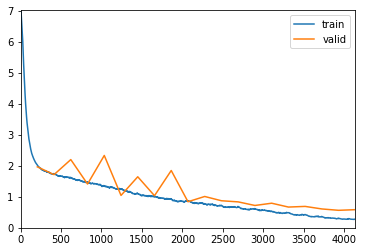

Better model found at epoch 0 with valid_loss value: 1.9661256074905396.
Better model found at epoch 1 with valid_loss value: 1.7146409749984741.
Better model found at epoch 3 with valid_loss value: 1.4108681678771973.
Better model found at epoch 5 with valid_loss value: 1.044122576713562.
Better model found at epoch 7 with valid_loss value: 1.0350250005722046.
Better model found at epoch 9 with valid_loss value: 0.8406067490577698.
Better model found at epoch 12 with valid_loss value: 0.8356364965438843.
Better model found at epoch 13 with valid_loss value: 0.7200154066085815.
Better model found at epoch 15 with valid_loss value: 0.6687899231910706.
Better model found at epoch 17 with valid_loss value: 0.6076143980026245.
Better model found at epoch 18 with valid_loss value: 0.5636857748031616.


In [58]:
learn.fit_one_cycle(20,max_lr=5e-2)

Novograd optimizer loaded...


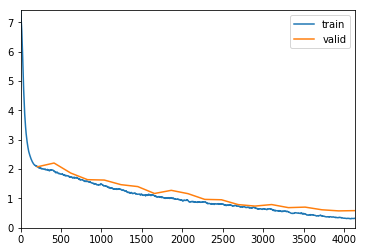

Better model found at epoch 0 with valid_loss value: 2.07844614982605.
Better model found at epoch 2 with valid_loss value: 1.8649048805236816.
Better model found at epoch 3 with valid_loss value: 1.64011812210083.
Better model found at epoch 4 with valid_loss value: 1.62735915184021.
Better model found at epoch 5 with valid_loss value: 1.4698538780212402.
Better model found at epoch 6 with valid_loss value: 1.404926061630249.
Better model found at epoch 7 with valid_loss value: 1.169120192527771.
Better model found at epoch 9 with valid_loss value: 1.1638598442077637.
Better model found at epoch 10 with valid_loss value: 0.968496561050415.
Better model found at epoch 11 with valid_loss value: 0.9556220173835754.
Better model found at epoch 12 with valid_loss value: 0.7907557487487793.
Better model found at epoch 13 with valid_loss value: 0.7399018406867981.
Better model found at epoch 15 with valid_loss value: 0.6869480609893799.
Better model found at epoch 17 with valid_loss value: 0

In [51]:
learn.fit_one_cycle(20,max_lr=5e-2)

Novograd optimizer loaded...


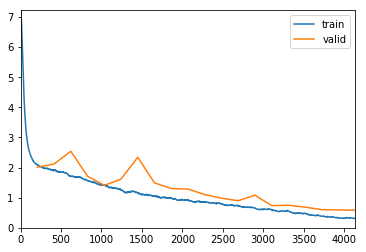

Better model found at epoch 0 with valid_loss value: 2.0107767581939697.
Better model found at epoch 3 with valid_loss value: 1.7134228944778442.
Better model found at epoch 4 with valid_loss value: 1.4083408117294312.
Better model found at epoch 8 with valid_loss value: 1.3043240308761597.
Better model found at epoch 9 with valid_loss value: 1.284460186958313.
Better model found at epoch 10 with valid_loss value: 1.1033170223236084.
Better model found at epoch 11 with valid_loss value: 0.9824103116989136.
Better model found at epoch 12 with valid_loss value: 0.8988101482391357.
Better model found at epoch 14 with valid_loss value: 0.7356670498847961.
Better model found at epoch 16 with valid_loss value: 0.6855978965759277.
Better model found at epoch 17 with valid_loss value: 0.6029892563819885.
Better model found at epoch 18 with valid_loss value: 0.5926023721694946.
Better model found at epoch 19 with valid_loss value: 0.5832480192184448.


In [44]:
learn.fit_one_cycle(20,max_lr=5e-2)

Novograd optimizer loaded...


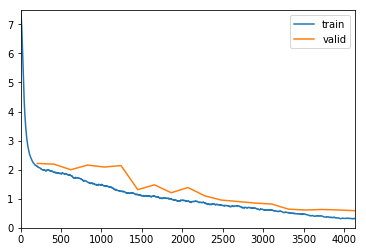

Better model found at epoch 0 with valid_loss value: 2.2137227058410645.
Better model found at epoch 1 with valid_loss value: 2.189021110534668.
Better model found at epoch 2 with valid_loss value: 1.9970229864120483.
Better model found at epoch 6 with valid_loss value: 1.3130724430084229.
Better model found at epoch 8 with valid_loss value: 1.2064834833145142.
Better model found at epoch 10 with valid_loss value: 1.1002519130706787.
Better model found at epoch 11 with valid_loss value: 0.952981173992157.
Better model found at epoch 12 with valid_loss value: 0.9031475186347961.
Better model found at epoch 13 with valid_loss value: 0.8512471914291382.
Better model found at epoch 14 with valid_loss value: 0.8176097869873047.
Better model found at epoch 15 with valid_loss value: 0.6424024701118469.
Better model found at epoch 16 with valid_loss value: 0.6121180057525635.
Better model found at epoch 19 with valid_loss value: 0.5871570110321045.


In [37]:
learn.fit_one_cycle(20,max_lr=5e-2)

Novograd optimizer loaded...


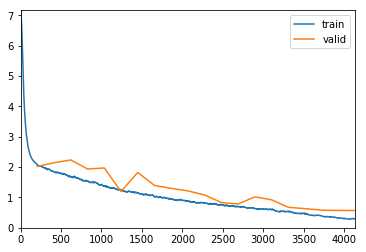

Better model found at epoch 0 with valid_loss value: 2.0211777687072754.
Better model found at epoch 3 with valid_loss value: 1.937097430229187.
Better model found at epoch 5 with valid_loss value: 1.1966073513031006.
Better model found at epoch 10 with valid_loss value: 1.079334020614624.
Better model found at epoch 11 with valid_loss value: 0.8309172987937927.
Better model found at epoch 12 with valid_loss value: 0.7854161262512207.
Better model found at epoch 15 with valid_loss value: 0.6744500994682312.
Better model found at epoch 16 with valid_loss value: 0.6310220956802368.
Better model found at epoch 17 with valid_loss value: 0.581060528755188.
Better model found at epoch 18 with valid_loss value: 0.5735152363777161.
Better model found at epoch 19 with valid_loss value: 0.5698401927947998.


In [30]:
learn.fit_one_cycle(20,max_lr=5e-2)

Novograd optimizer loaded...


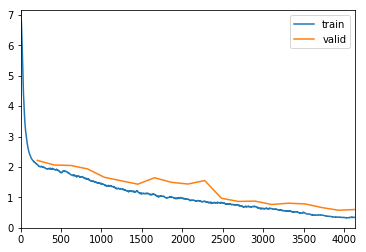

Better model found at epoch 0 with valid_loss value: 2.215919017791748.
Better model found at epoch 1 with valid_loss value: 2.06474232673645.
Better model found at epoch 2 with valid_loss value: 2.04840350151062.
Better model found at epoch 3 with valid_loss value: 1.935045599937439.
Better model found at epoch 4 with valid_loss value: 1.660512924194336.
Better model found at epoch 5 with valid_loss value: 1.5463495254516602.
Better model found at epoch 6 with valid_loss value: 1.4330811500549316.
Better model found at epoch 11 with valid_loss value: 0.971754252910614.
Better model found at epoch 12 with valid_loss value: 0.8665772676467896.
Better model found at epoch 14 with valid_loss value: 0.7656433582305908.
Better model found at epoch 17 with valid_loss value: 0.6646633148193359.
Better model found at epoch 18 with valid_loss value: 0.5776975750923157.


In [23]:
learn.fit_one_cycle(20,max_lr=6e-2)

Novograd optimizer loaded...


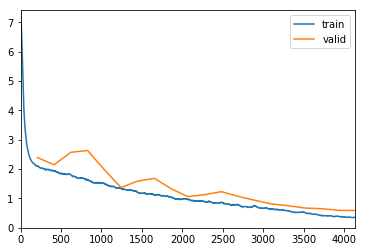

Better model found at epoch 0 with valid_loss value: 2.3935718536376953.
Better model found at epoch 1 with valid_loss value: 2.144376277923584.
Better model found at epoch 4 with valid_loss value: 1.9810587167739868.
Better model found at epoch 5 with valid_loss value: 1.3719308376312256.
Better model found at epoch 8 with valid_loss value: 1.3274726867675781.
Better model found at epoch 9 with valid_loss value: 1.0622081756591797.
Better model found at epoch 13 with valid_loss value: 0.9365229606628418.
Better model found at epoch 14 with valid_loss value: 0.8117498159408569.
Better model found at epoch 15 with valid_loss value: 0.7518101334571838.
Better model found at epoch 16 with valid_loss value: 0.671279788017273.
Better model found at epoch 17 with valid_loss value: 0.6511498093605042.
Better model found at epoch 18 with valid_loss value: 0.5954638123512268.
Better model found at epoch 19 with valid_loss value: 0.5871118307113647.


In [16]:
learn.fit_one_cycle(20,max_lr=7e-2)

In [39]:
learn.callback_fns.pop()

functools.partial(<class 'fastai.callbacks.tracker.SaveModelCallback'>, name='model-novotest-1', metric='error_rate')

In [16]:
learn.lr_find()

Novograd optimizer loaded...


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


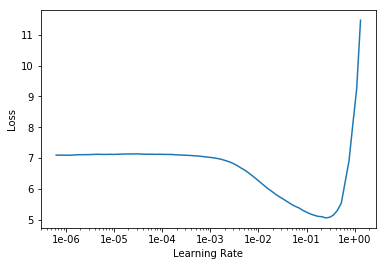

In [17]:
learn.recorder.plot()

In [34]:
#learn.fit_one_cycle(5,max_lr=8e-2) 

Novograd optimizer loaded...


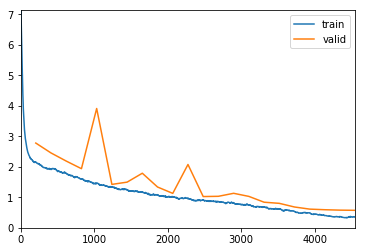

Better model found at epoch 0 with error_rate value: 0.8240000009536743.


In [49]:
learn.fit_one_cycle(22,max_lr=9e-2) 

In [42]:
learn.fit_one_cycle(22,max_lr=6e-3) 

Novograd optimizer loaded...


Better model found at epoch 0 with error_rate value: 0.7580000162124634.


Novograd optimizer loaded...


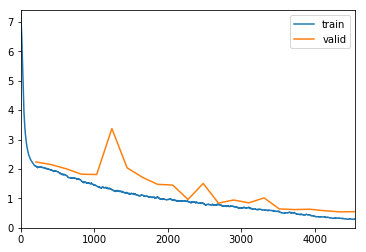

Better model found at epoch 0 with error_rate value: 0.8059999942779541.


In [26]:
learn.fit_one_cycle(22,max_lr=6e-1) 

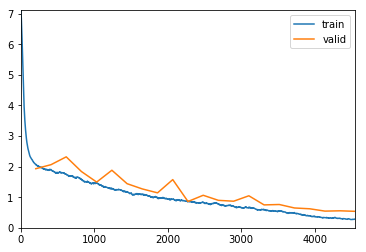

Better model found at epoch 0 with error_rate value: 0.6679999828338623.
Better model found at epoch 0 with error_rate value: 0.6679999828338623.
Better model found at epoch 1 with error_rate value: 0.722000002861023.
Better model found at epoch 1 with error_rate value: 0.722000002861023.
Better model found at epoch 2 with error_rate value: 0.7400000095367432.
Better model found at epoch 2 with error_rate value: 0.7400000095367432.


In [19]:
learn.fit_one_cycle(22,max_lr=5e-2) 

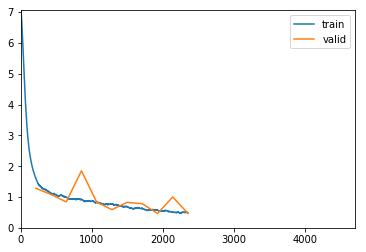

/home/ubuntu/anaconda3/lib/python3.7/site-packages/fastai/callbacks/tracker.py:50: UserWarning: <class 'fastai.callbacks.tracker.SaveModelCallback'> conditioned on metric `error_rate` which is not available. Available metrics are: train_loss, valid_loss, accuracy
  warn(f'{self.__class__} conditioned on metric `{self.monitor}` which is not available. Available metrics are: {", ".join(map(str, self.learn.recorder.names[1:-1]))}')


In [ ]:
learn.fit_one_cycle(22,max_lr=3e-2) 

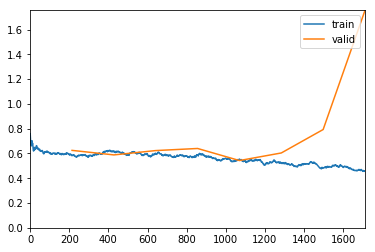

Better model found at epoch 0 with valid_loss value: 0.6249366402626038.
Better model found at epoch 1 with valid_loss value: 0.5883650779724121.
Better model found at epoch 4 with valid_loss value: 0.5428622961044312.


In [31]:
learn.fit_one_cycle(8,max_lr=5e-2) 

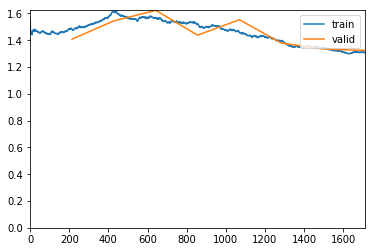

Better model found at epoch 0 with valid_loss value: 1.408400058746338.
Better model found at epoch 5 with valid_loss value: 1.378934383392334.
Better model found at epoch 6 with valid_loss value: 1.3349106311798096.
Better model found at epoch 7 with valid_loss value: 1.32388174533844.


In [18]:
learn.fit_one_cycle(8,max_lr=5e-2) 

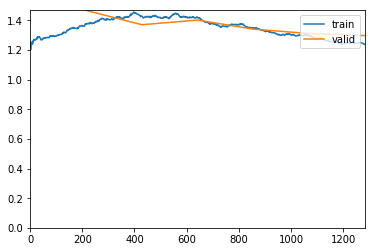

Better model found at epoch 0 with valid_loss value: 1.4677400588989258.
Better model found at epoch 1 with valid_loss value: 1.370765209197998.
Better model found at epoch 3 with valid_loss value: 1.3407654762268066.
Better model found at epoch 4 with valid_loss value: 1.3114373683929443.
Better model found at epoch 5 with valid_loss value: 1.2976598739624023.


In [19]:
learn.fit_one_cycle(6,max_lr=4e-2) 

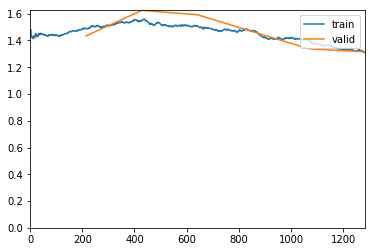

Better model found at epoch 0 with valid_loss value: 1.4335322380065918.
Better model found at epoch 4 with valid_loss value: 1.3370707035064697.
Better model found at epoch 5 with valid_loss value: 1.3157331943511963.


In [83]:
learn.fit_one_cycle(6,max_lr=5e-2)

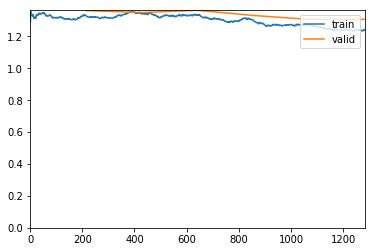

Better model found at epoch 0 with valid_loss value: 1.3621963262557983.
Better model found at epoch 1 with valid_loss value: 1.3498948812484741.
Better model found at epoch 3 with valid_loss value: 1.3316216468811035.
Better model found at epoch 4 with valid_loss value: 1.3067505359649658.


In [84]:
learn.fit_one_cycle(6,max_lr=2e-2)

Novograd optimizer loaded...


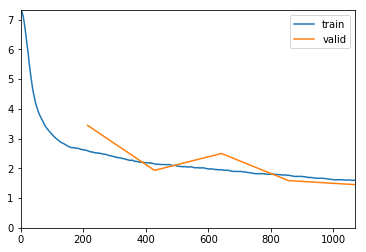

Better model found at epoch 0 with valid_loss value: 3.44478440284729.
Better model found at epoch 1 with valid_loss value: 1.931881308555603.
Better model found at epoch 3 with valid_loss value: 1.5875449180603027.
Better model found at epoch 4 with valid_loss value: 1.4510973691940308.


In [65]:
learn.fit_one_cycle(5,max_lr=5e-2) 

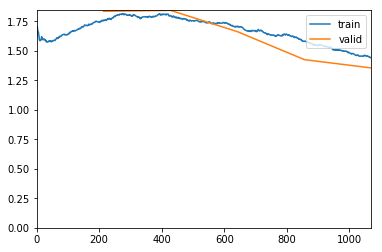

Better model found at epoch 0 with valid_loss value: 1.8350552320480347.
Better model found at epoch 2 with valid_loss value: 1.6621723175048828.
Better model found at epoch 3 with valid_loss value: 1.4251619577407837.
Better model found at epoch 4 with valid_loss value: 1.354781985282898.


In [66]:
learn.fit_one_cycle(5,max_lr=6e-2) 

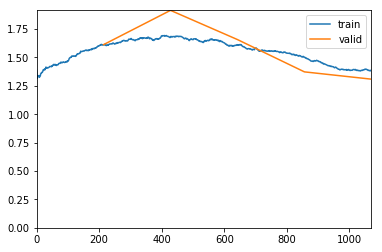

Better model found at epoch 0 with valid_loss value: 1.6120684146881104.
Better model found at epoch 3 with valid_loss value: 1.3725067377090454.
Better model found at epoch 4 with valid_loss value: 1.3083255290985107.


In [67]:
learn.fit_one_cycle(5,max_lr=7e-2) 

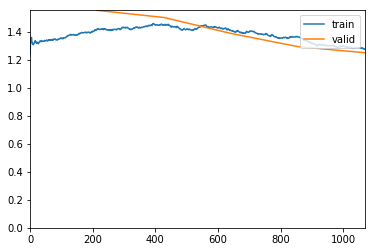

Better model found at epoch 0 with valid_loss value: 1.5527232885360718.
Better model found at epoch 1 with valid_loss value: 1.5015628337860107.
Better model found at epoch 2 with valid_loss value: 1.3877263069152832.
Better model found at epoch 3 with valid_loss value: 1.2935599088668823.
Better model found at epoch 4 with valid_loss value: 1.2501059770584106.


In [68]:
learn.fit_one_cycle(5,max_lr=4e-2) 

In [58]:
learn.fit_one_cycle(20,max_lr=3e-2) 

Novograd optimizer loaded...


Better model found at epoch 0 with valid_loss value: 2.351478338241577.
Better model found at epoch 1 with valid_loss value: 2.247011661529541.
Better model found at epoch 2 with valid_loss value: 2.0894784927368164.
Better model found at epoch 4 with valid_loss value: 1.8160396814346313.
Better model found at epoch 7 with valid_loss value: 1.5974560976028442.
Better model found at epoch 9 with valid_loss value: 1.5178771018981934.
Better model found at epoch 10 with valid_loss value: 1.5009593963623047.
Better model found at epoch 11 with valid_loss value: 1.4437801837921143.
Better model found at epoch 12 with valid_loss value: 1.3722184896469116.
Better model found at epoch 14 with valid_loss value: 1.3403550386428833.
Better model found at epoch 16 with valid_loss value: 1.2996127605438232.
Better model found at epoch 17 with valid_loss value: 1.2760072946548462.
Better model found at epoch 18 with valid_loss value: 1.262330174446106.


Novograd optimizer loaded...


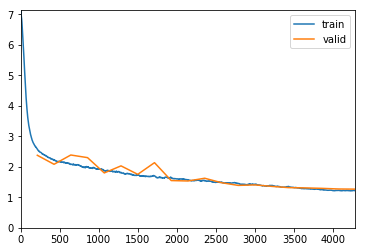

Better model found at epoch 0 with valid_loss value: 2.3778891563415527.
Better model found at epoch 1 with valid_loss value: 2.082507848739624.
Better model found at epoch 4 with valid_loss value: 1.7990471124649048.
Better model found at epoch 6 with valid_loss value: 1.7531908750534058.
Better model found at epoch 8 with valid_loss value: 1.5488171577453613.
Better model found at epoch 9 with valid_loss value: 1.5350133180618286.
Better model found at epoch 11 with valid_loss value: 1.4786288738250732.
Better model found at epoch 12 with valid_loss value: 1.3905107975006104.
Better model found at epoch 14 with valid_loss value: 1.358682632446289.
Better model found at epoch 15 with valid_loss value: 1.3177071809768677.
Better model found at epoch 16 with valid_loss value: 1.3083856105804443.
Better model found at epoch 17 with valid_loss value: 1.2935112714767456.
Better model found at epoch 18 with valid_loss value: 1.272796630859375.
Better model found at epoch 19 with valid_loss 

In [45]:
learn.fit_one_cycle(20,max_lr=2e-2) 

Novograd optimizer loaded...


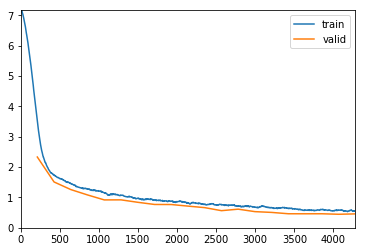

Better model found at epoch 0 with valid_loss value: 2.3319175243377686.
Better model found at epoch 1 with valid_loss value: 1.5102927684783936.
Better model found at epoch 2 with valid_loss value: 1.2597246170043945.
Better model found at epoch 3 with valid_loss value: 1.0826451778411865.
Better model found at epoch 4 with valid_loss value: 0.9188634753227234.
Better model found at epoch 6 with valid_loss value: 0.8404183387756348.
Better model found at epoch 7 with valid_loss value: 0.7689138054847717.
Better model found at epoch 8 with valid_loss value: 0.7668935656547546.
Better model found at epoch 9 with valid_loss value: 0.7146055102348328.
Better model found at epoch 10 with valid_loss value: 0.6643136143684387.
Better model found at epoch 11 with valid_loss value: 0.5642959475517273.
Better model found at epoch 13 with valid_loss value: 0.5325294137001038.
Better model found at epoch 14 with valid_loss value: 0.5069172382354736.
Better model found at epoch 15 with valid_loss 

In [28]:
learn.fit_one_cycle(20,max_lr=3e-3) 

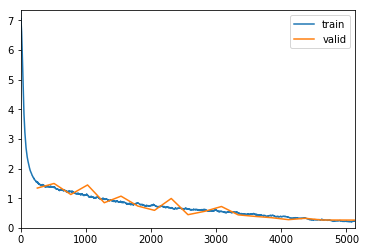

Better model found at epoch 0 with valid_loss value: 1.3418073654174805.
Better model found at epoch 2 with valid_loss value: 1.1246848106384277.
Better model found at epoch 4 with valid_loss value: 0.8466264605522156.
Better model found at epoch 6 with valid_loss value: 0.7349520921707153.
Better model found at epoch 7 with valid_loss value: 0.5893415212631226.
Better model found at epoch 9 with valid_loss value: 0.44256553053855896.
Better model found at epoch 12 with valid_loss value: 0.43689438700675964.
Better model found at epoch 13 with valid_loss value: 0.3852481544017792.
Better model found at epoch 14 with valid_loss value: 0.3412241041660309.
Better model found at epoch 15 with valid_loss value: 0.2752193212509155.
Better model found at epoch 17 with valid_loss value: 0.2634849548339844.
Better model found at epoch 18 with valid_loss value: 0.26167482137680054.
Better model found at epoch 19 with valid_loss value: 0.26004260778427124.


In [20]:
learn.fit_one_cycle(20,max_lr=4e-2)  #fire off a run - Novograd!